In [1]:
library(dplyr)
library(tidyverse)
library(data.table)
library(bedr)
library(readr)

options(readr.num_columns = 0)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"'timedatectl' indicates the non-existent timezone name 'n/a'"
unable to deduce timezone name from 'America/Chicago'

-- Attaching packages ------------------------------------------------------------------------------------------------------------------------------------------------------ tidyverse 1.3.1 --

v ggplot2 3.4.1     v purrr   0.3.4
v tibble  3.2.1     v stringr 1.4.0
v tidyr   1.1.3     v forcats 0.5.1
v readr   1.4.0     

-- Conflicts --------------------------------------------------------------------------------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


Attaching package: 'data.table'


The following object is masked from 

In [2]:
dir <- "/project2/yangili1/bjf79/ChromatinSplicingQTLs/"
colocs <- read_tsv(paste0(dir, "output/GwasColocs_by_MolQTLCategory_ForCarlos.YRI_Only.tsv.gz"), )

In [ ]:
token =  'aac50eadb263'

In [3]:
loci_list <- colocs %>% filter(ColocCategory == 'sQTL+eQTL colocs', PosteriorColocalizationPr > 0.8) %>%
    pull(GWAS.Loci) %>% unique()




In [4]:
colocs %>% filter(ColocCategory == 'sQTL+eQTL colocs', PosteriorColocalizationPr >= 0.4) %>%
    pull(GWAS.accession) %>% unique()

[1] "GCST004616" "GCST004626" "GCST004608" "GCST004618" "GCST004599"
 [6] "GCST004609" "GCST004619" "GCST004629" "GCST004610" "GCST004620"
[11] "GCST004630" "GCST004611" "GCST004621" "GCST004631" "GCST004602"
[16] "GCST004612" "GCST004622" "GCST004613" "GCST004633" "GCST004614"

In [5]:
colocs %>% filter(ColocCategory == 'sQTL+eQTL colocs') %>% pull(PosteriorColocalizationPr) %>% min()

[1] 0.3184

In [6]:
colocs <-  colocs %>% mutate(
    Trait_name = Trait %>% str_extract(., "(?<=;)[^;]+$")
    )


In [7]:
colocs_ <- colocs %>% filter(ColocCategory == 'sQTL+eQTL colocs', PosteriorColocalizationPr >= 0.2)

In [8]:
library(dplyr)


In [9]:
# Create a new column 'Gene' with empty strings
colocs_ <- colocs_ %>% mutate(Gene = "")

# Group by unique GWAS.Loci values
colocs_ <- colocs_ %>% group_by(GWAS.Loci) %>% 
  # For each group
  mutate(
    # If PhenotypeClass is Expression.Splicing.Subset_YRI or chRNA.Expression.Splicing
    # select the unique gene name
    Gene = if_else(
      as.character(PhenotypeClass) %in% c("Expression.Splicing.Subset_YRI", "chRNA.Expression.Splicing"), 
      as.character(Trait_name),#paste(unique(Trait_name), collapse = ";"), 
      # Otherwise, fill in the gene name from the first row with the same GWAS.Loci and PhenotypeClass
      first(colocs_[colocs_$GWAS.Loci == cur_group()[["GWAS.Loci"]] & 
                 (colocs_$PhenotypeClass == "Expression.Splicing.Subset_YRI" |
                    colocs_$PhenotypeClass == "chRNA.Expression.Splicing"), "Trait_name"]) %>% 
        pull()
    )
  ) %>% 
  # Remove the grouping
  ungroup()


In [10]:
gene_bed <- read_tsv('../code/ExpressionAnalysis/polyA/ExpressedGeneList.txt', 
                     col_names = c('chrom', 'start', 'end', 'gene_name', 'score', 'strand') )

In [11]:
gene_bed %>% filter(gene_name == 'ENSG00000107404.20') %>% pull(chrom)#select(chrom, start, end) %>% pull(chrom)

[1] "chr1"

In [93]:
gene_list <- colocs_ %>% filter(PhenotypeClass == 'GWAS')  %>% pull(Gene) %>% unique()

In [95]:
gene_list

[1] "ENSG00000114735.9"  "ENSG00000122481.17" "ENSG00000085514.16"
 [4] "ENSG00000183323.13" "ENSG00000183955.13" "ENSG00000166913.13"
 [7] "ENSG00000007341.19" "ENSG00000166532.16" "ENSG00000141295.14"
[10] "ENSG00000121417.14" "ENSG00000077420.16" "ENSG00000107796.13"
[13] "ENSG00000082146.13"

In [100]:
process_slice_gene <- function(colocs, gene_bed, geneName){
    
    dir <- "/project2/yangili1/bjf79/ChromatinSplicingQTLs/"
    
    colocs_ <- colocs[colocs$Gene == geneName,]
    
#     colocs_ %>% dim() %>% print()
        
#     geneName %>% print()
    
    chrom <- gene_bed %>% filter(gene_name == geneName) %>% pull(chrom)
    start <- gene_bed %>% filter(gene_name == geneName) %>% pull(start) %>% as.integer()
    end <- gene_bed %>% filter(gene_name == geneName) %>% pull(end) %>% as.integer()
    
    
    
    
    from <- start -500001
    to <- end + 500001
    
#     print(chrom)
#     print(from)
#     print(to)
    
    
    coords <- paste0(chrom, ':', as.character(from), '-', as.character(to))

    
    unique_traits <- colocs_$Trait %>% unique()
    
#     print(unique_traits)
    for (trait in unique_traits) {
#         print(trait)
        assay <- gsub(';.*', '', trait)
        
        if (assay == 'GWAS'){
            
            gwas_chr_pos_name <- gsub('.*;', '', trait)
            
            gwas_chr_pos_name_split <- strsplit(gwas_chr_pos_name, "_")[[1]]
            
            
            GWAS_SNP_pos <- gwas_chr_pos_name_split[2]
            gwas_name <- gwas_chr_pos_name_split[3]
            
            gwas_locus_name <- gwas_chr_pos_name %>% gsub("_GCS", "_N_N_GCS", .)
            gwas_locus <- get_gwas_locus(gwas_name, gwas_locus_name)
            

            gwas_x <- gwas_locus %>% pull(start) %>% as.integer()
            gwas_y <- gwas_locus %>% pull(P) %>% as.numeric() %>% -log10(.)
            plot(gwas_x, gwas_y, xlab='coords', ylab=gwas_name)
            
            
            top_snp <- colocs_[colocs_$Trait==trait, 'TopCandidateSNP'][[1]]
        } else {
            
            QTL_df <- get_QTL_df(assay, coords, geneName, trait)
            
#             QTL_df %>% dim() %>% print()
            
            plot_QTL (QTL_df, assay)

        }
    }
    
    
}

get_gwas_locus <- function(gwas_name, gwas_locus_name){
#     print(gwas_name)
#     print(gwas_locus_name)
    gwas_file <- paste0(dir, 'code/gwas_summary_stats/StatsForColoc/', gwas_name, '.unstandardized.txt.gz')
    
    zcat_awk_cmd <- sprintf("zcat %s | awk -F '\\t' '{if (NR==1 || $(NF-1) == \"%s\") print }' -", gwas_file, gwas_locus_name)
    
    zcat_awk_output <- system(zcat_awk_cmd, intern = TRUE)
    
    tmp_file <- tempfile()
    writeLines(zcat_awk_output, tmp_file)

    gwas_locus <- read_tsv(tmp_file)

    file.remove(tmp_file)
    
    gwas_locus$hm_variant_id <- gsub('_', ':', gwas_locus$hm_variant_id)
    
    return(gwas_locus)
}

# get_gene_locus <- function(colocs_){
#     for (trait in colocs_$Trait) {
#         assay <- gsub(';.*', '', trait)
#         if (grepl('Expression.Splicing', assay)){
#             gene_locus <- gsub('.*;', '', trait)
#             return(gene_locus)
#         }
#     }
# }

get_QTL_df <- function(assay, coords, gene_locus, trait){
#     print(assay)
#     print(trait)
    phenotype_id <- paste(gsub('.*;', '', trait), gene_locus, sep=':')
#     print(assay)
#     print(phenotype_id)
    assay_file <- paste0(dir, 'code/QTLs/QTLTools/%s/NominalPassForColoc.txt.tabix.gz') %>% sprintf(., assay)
#     print(assay_file)
    phe_id <- paste()
#     print(coords)
#     print(assay_file)
#     print(phenotype_id)
#     print(coords)
    
#     print('.....')
#     print(assay_file)
#     print(phenotype_id)
    QTL_df <- tabix(coords, assay_file, check.chr=FALSE, verbose=FALSE) %>%
        filter(phe_id == phenotype_id)
    return (QTL_df)
}


plot_QTL <- function(QTL_df, assay){
    QTL_df_selected <- QTL_df %>% pull(var_id)
    
#     gwas_index <- match(QTL_df_selected, gwas_locus$hm_variant_id)
#     gwas_locus_ <- gwas_locus[gwas_index, ]

    QTL_index <- match(QTL_df_selected, QTL_df$var_id)
    QTL_df_ <- QTL_df[QTL_index, ]

    plot_x <- QTL_df %>% pull(var_from) %>% as.integer()
#     plot_gwas_y <- gwas_locus_ %>% pull(P) %>% as.numeric() %>% -log10(.)
    plot_QTL_y <- QTL_df_ %>% pull(nom_pval) %>% as.numeric() %>% -log10(.)
    tryCatch({
        plot(plot_x, plot_QTL_y, xlab = 'coords', ylab=assay)
    }, error=function(cond) {
            plot_QTL_y %>% length() %>% print()
        })
    
    
#     plot(plot_gwas_y, plot_QTL_y)

}


[1] "ENSG00000183323.13"


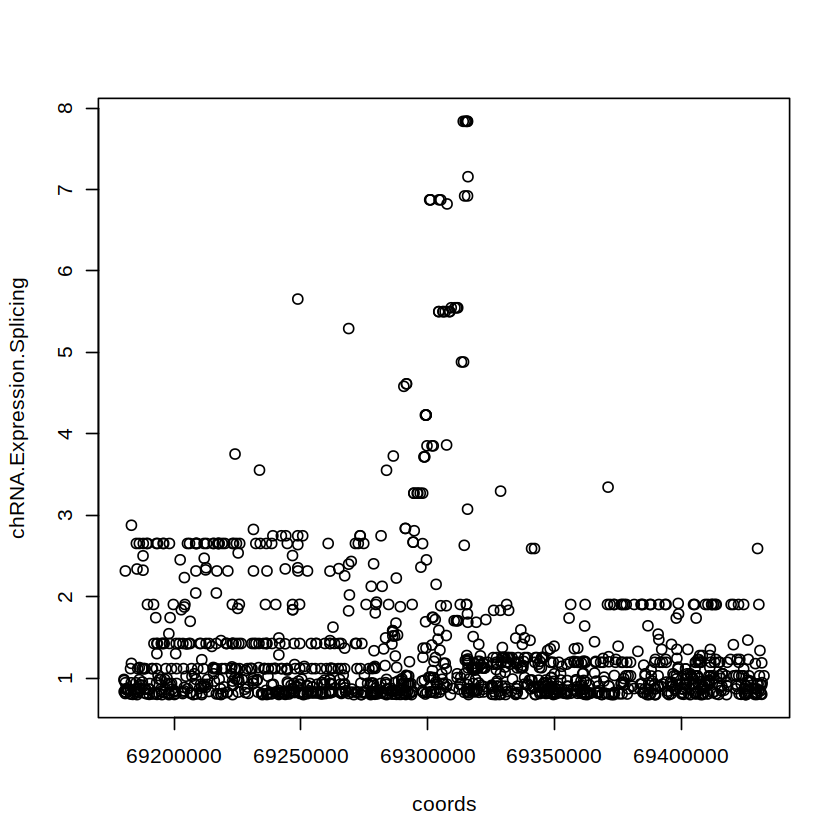

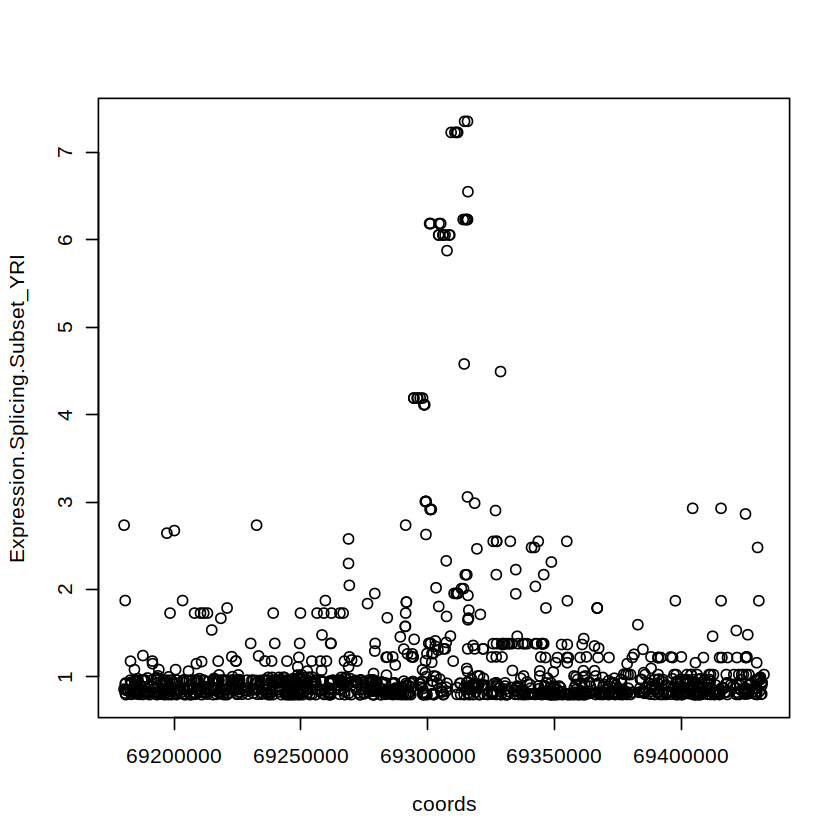

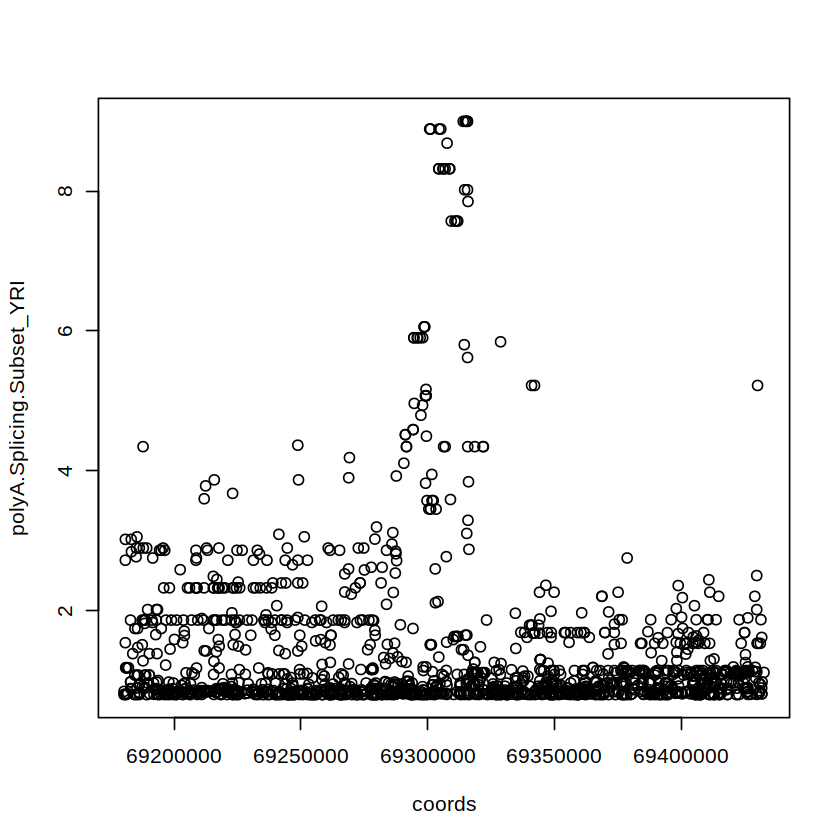

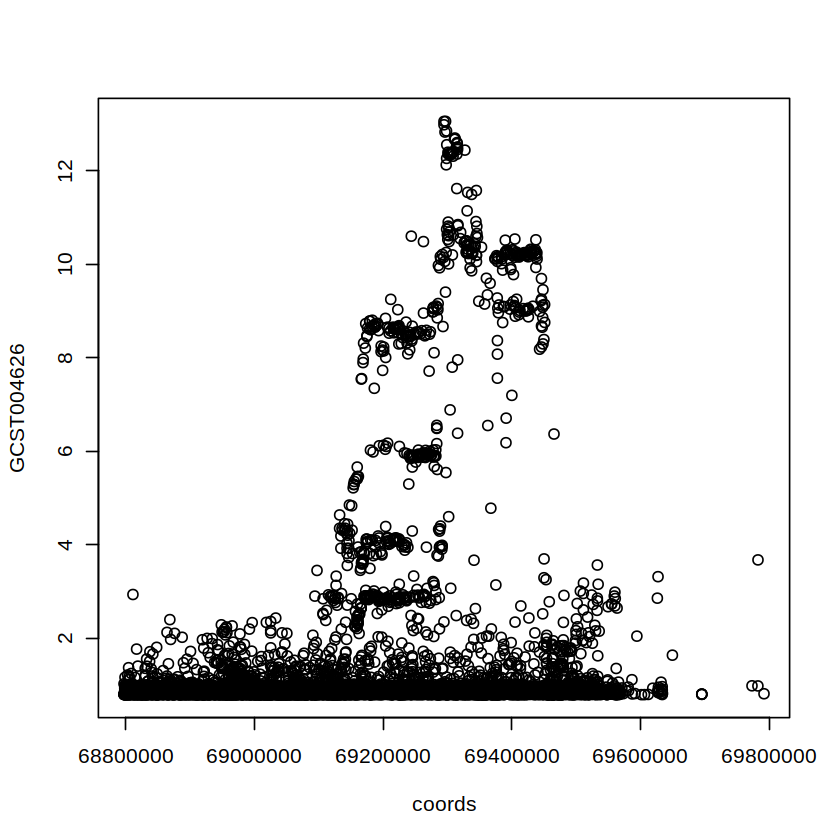

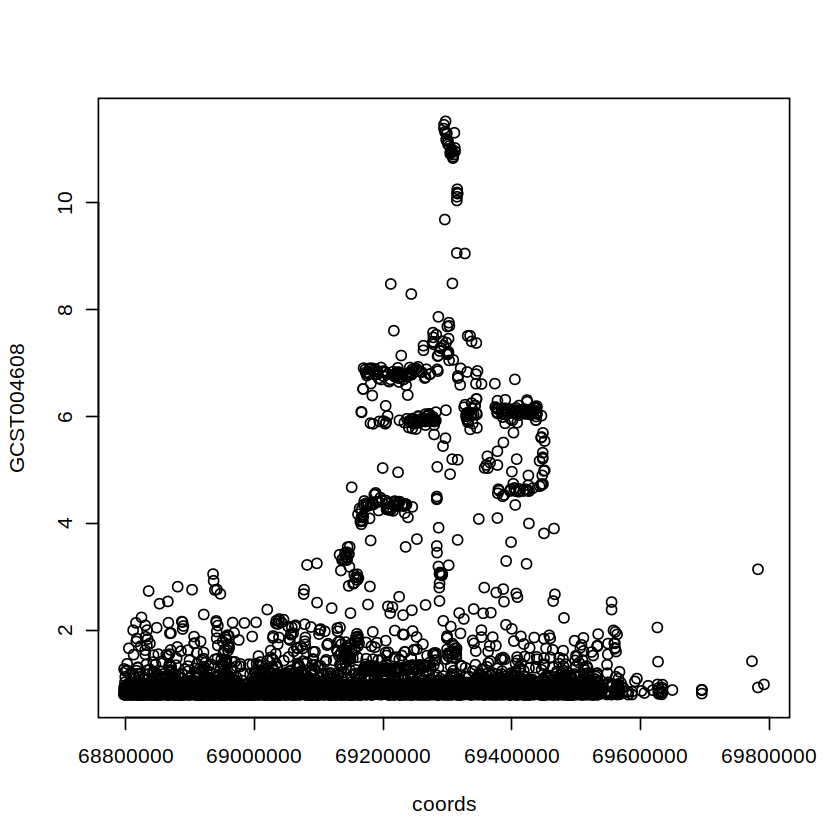

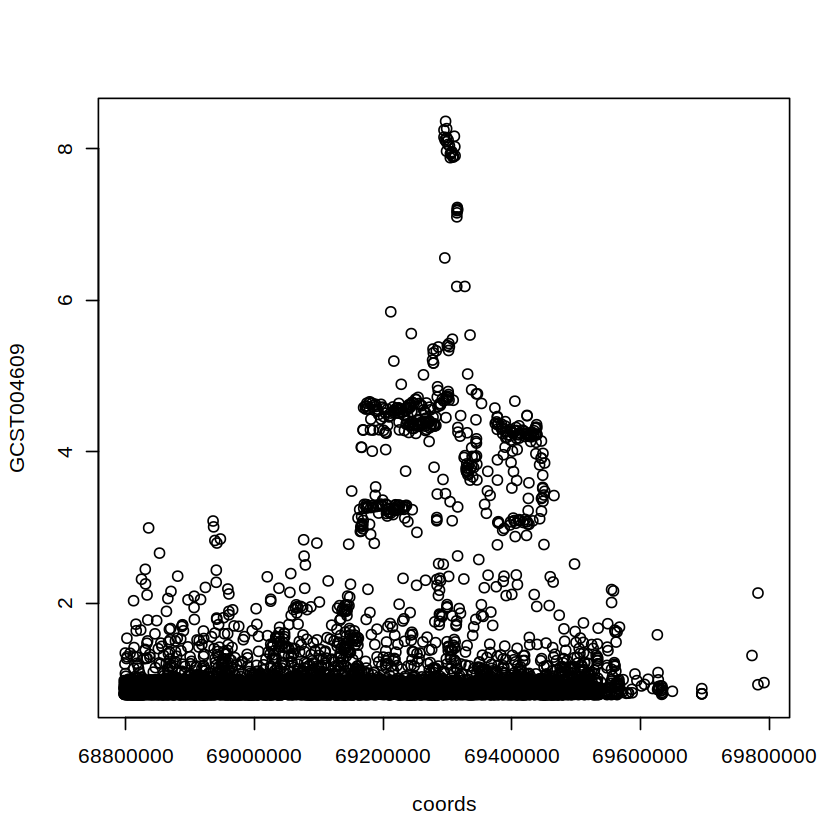

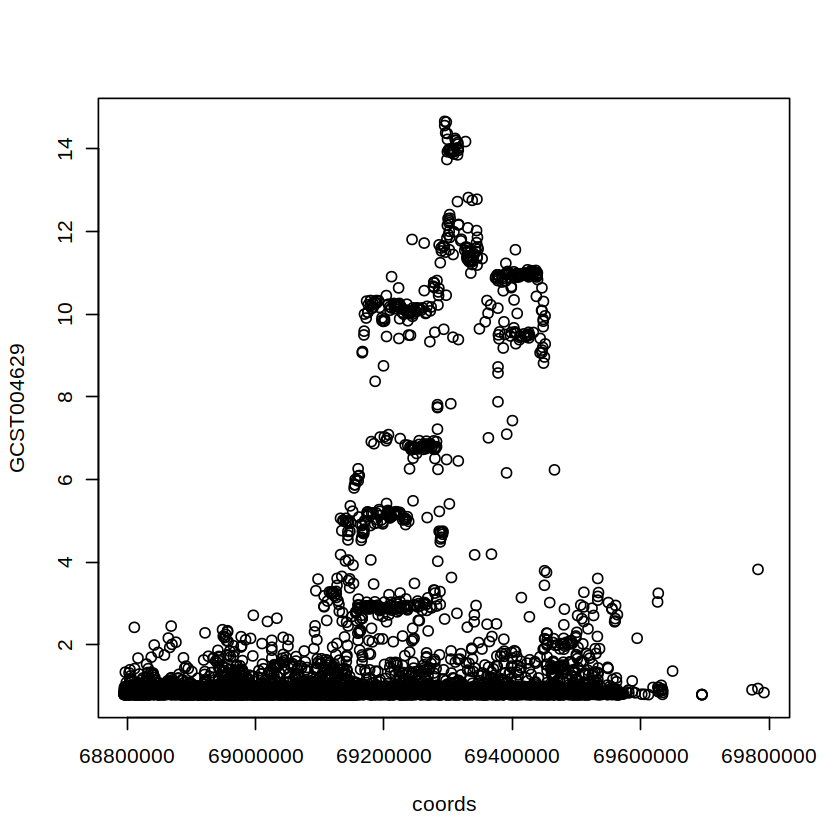

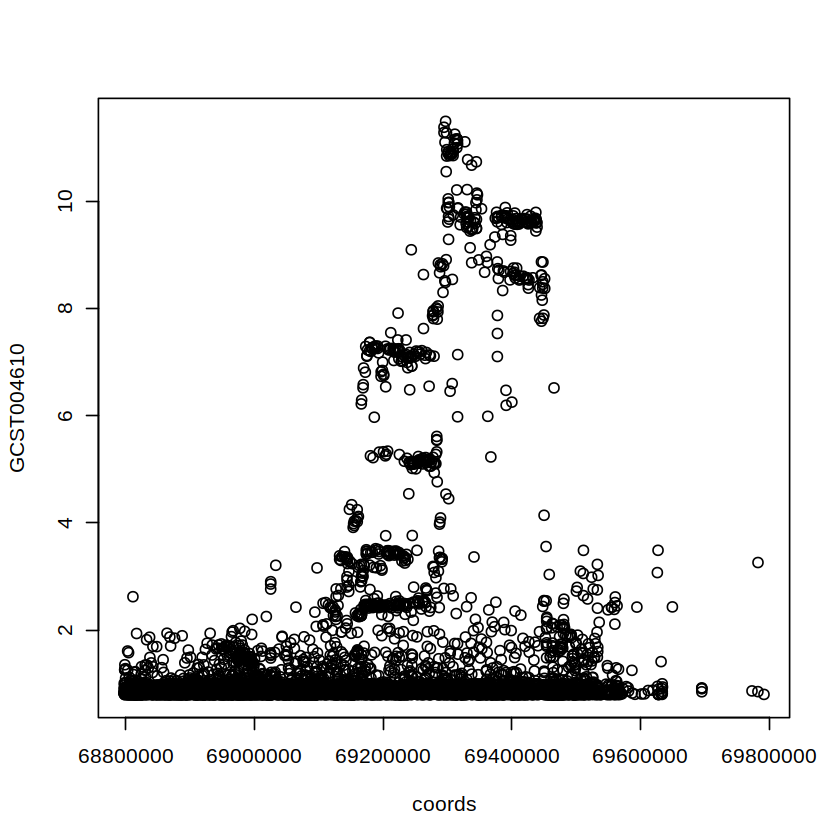

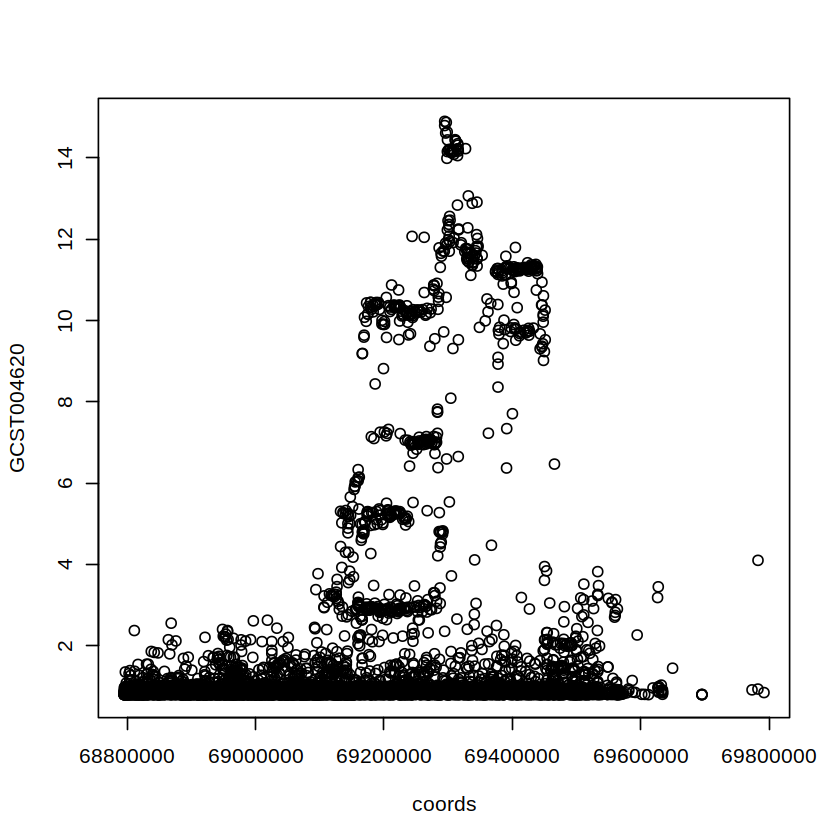

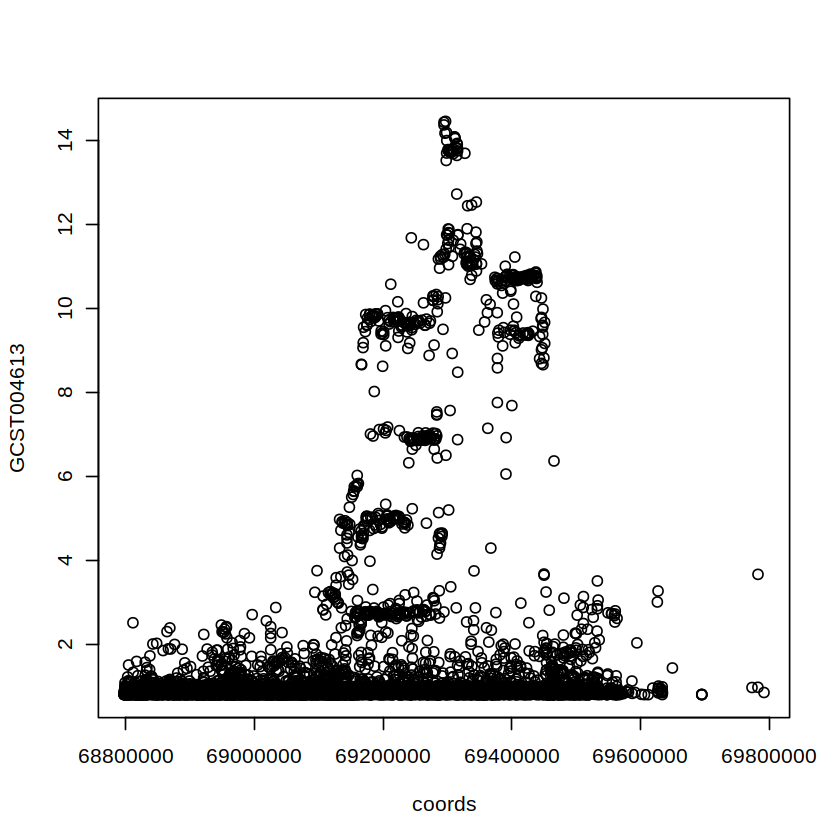

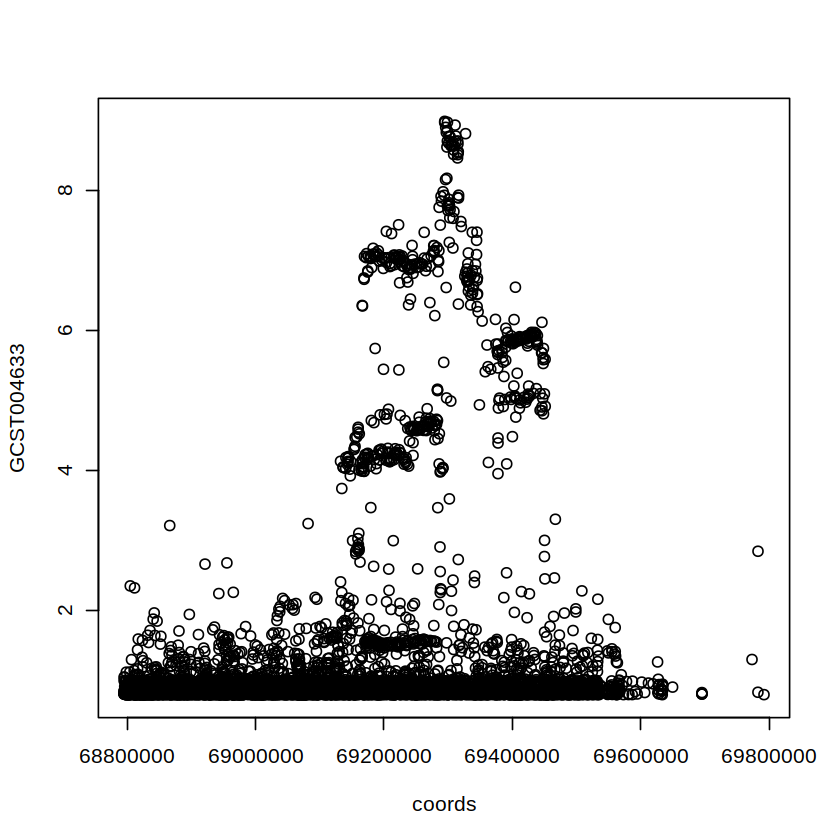

[1] "ENSG00000183955.13"


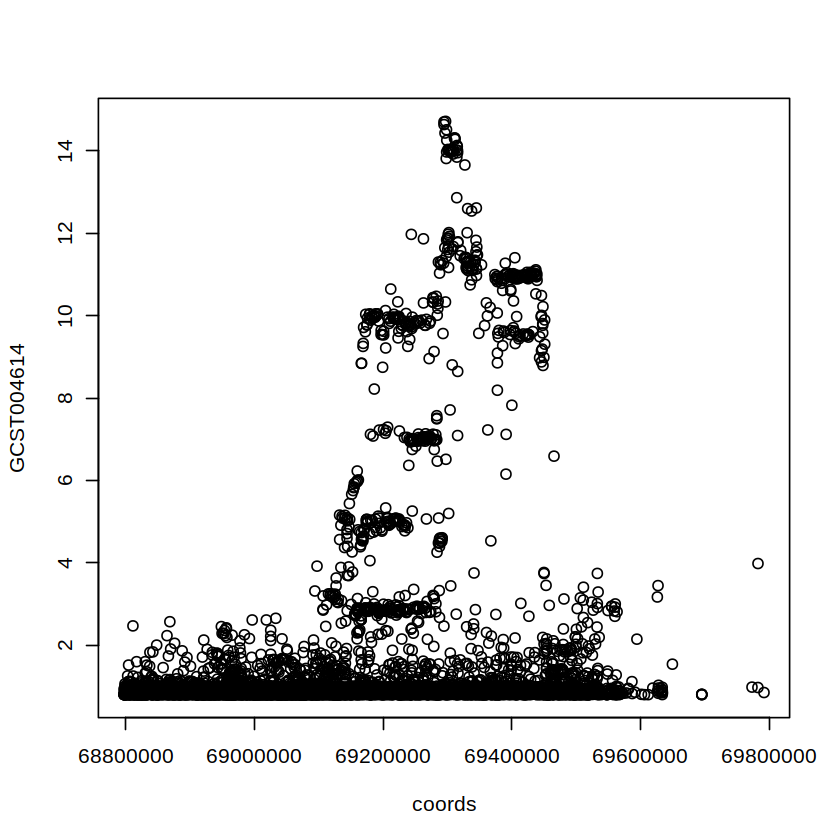

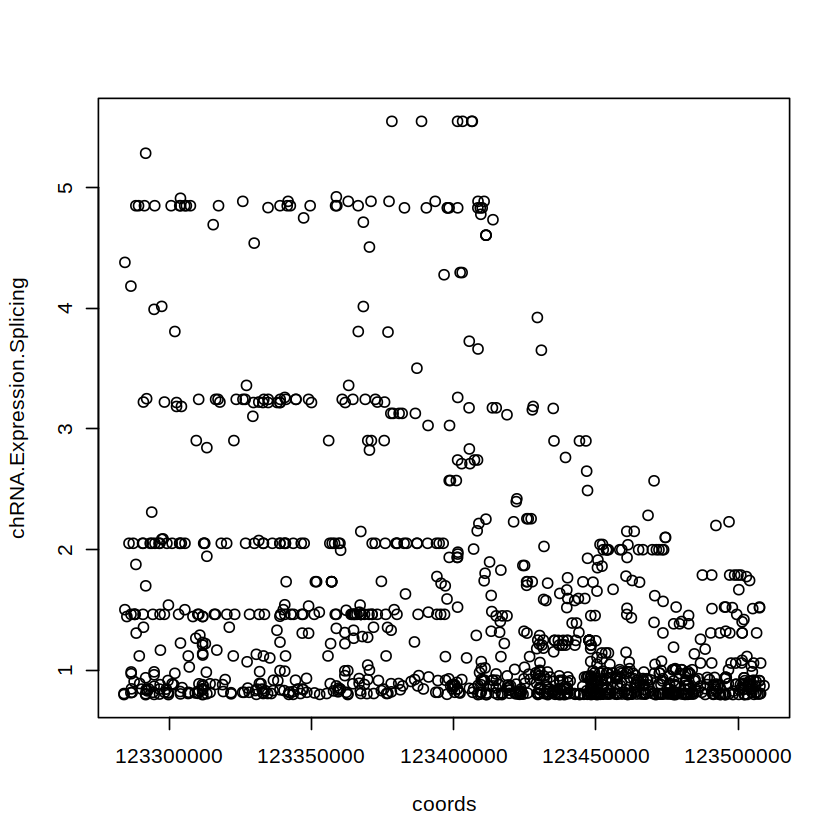

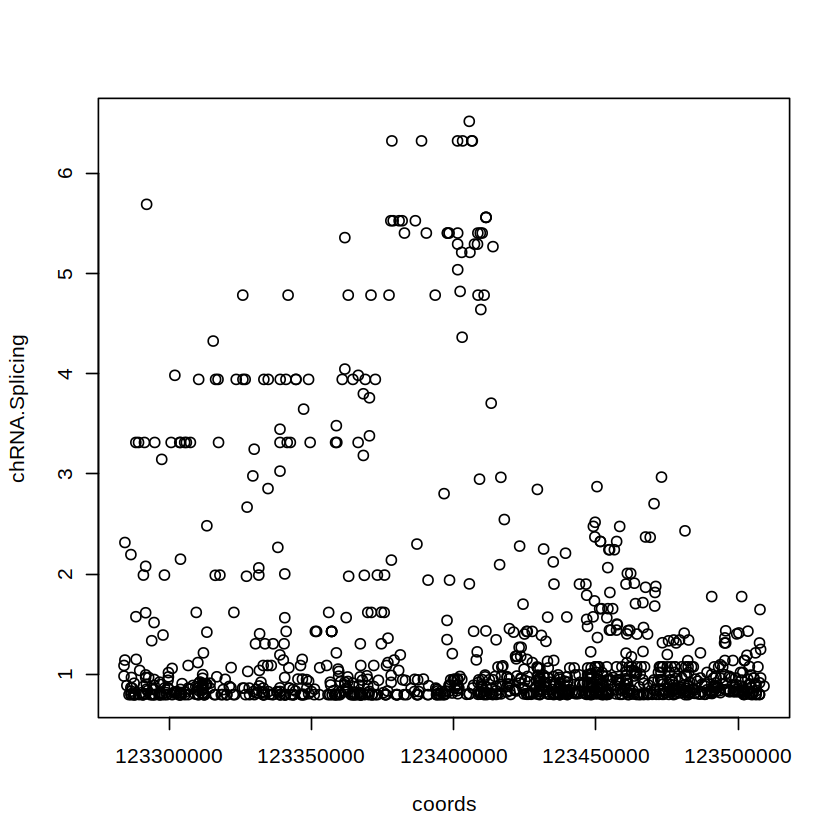

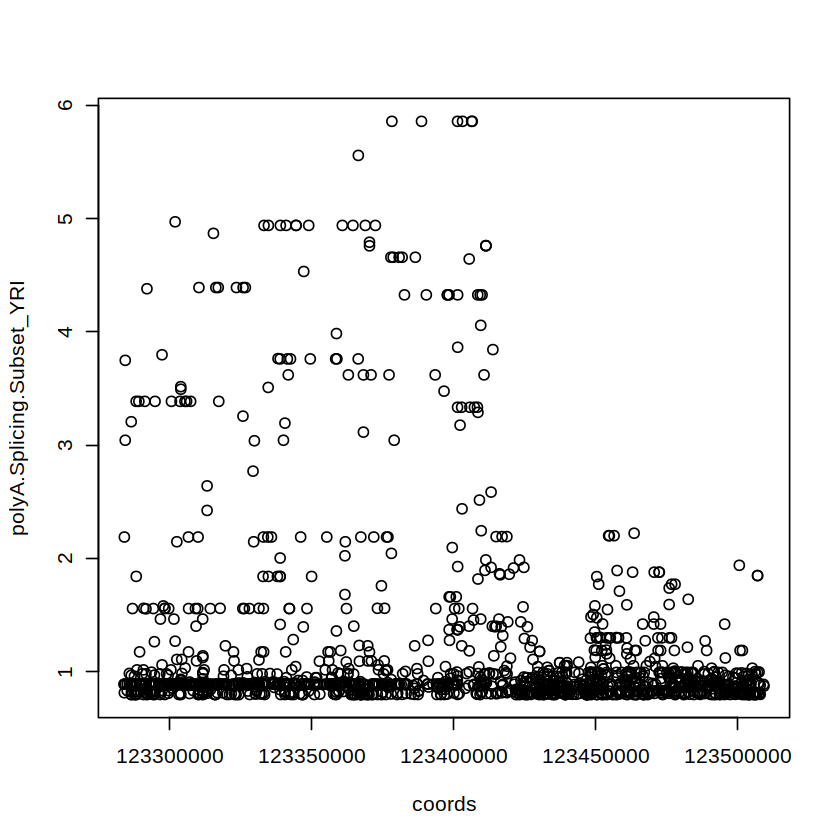

[1] "ENSG00000166913.13"


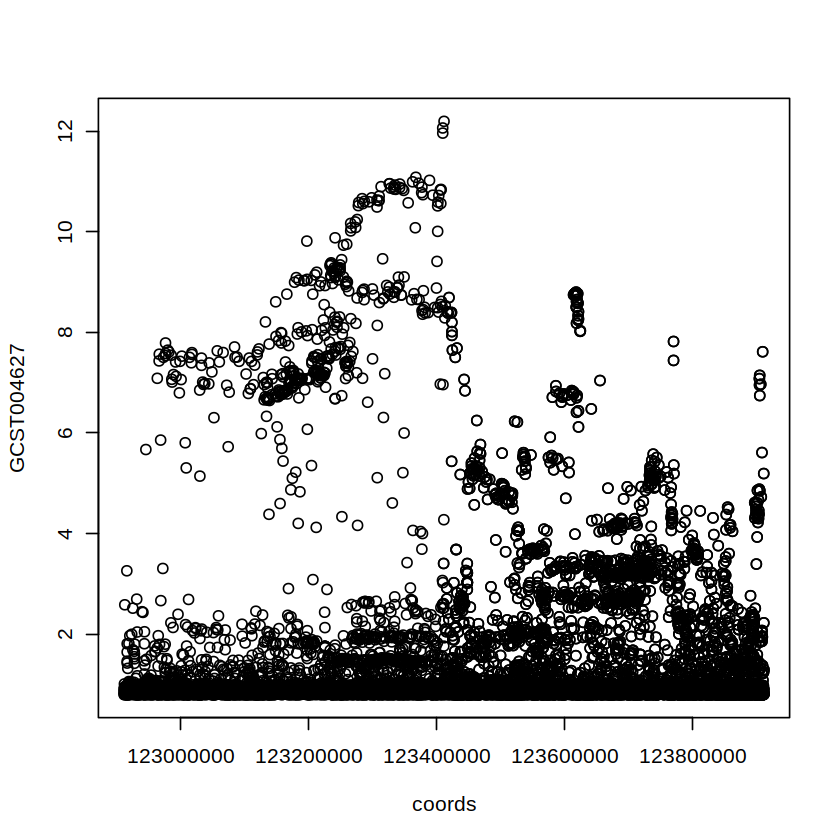

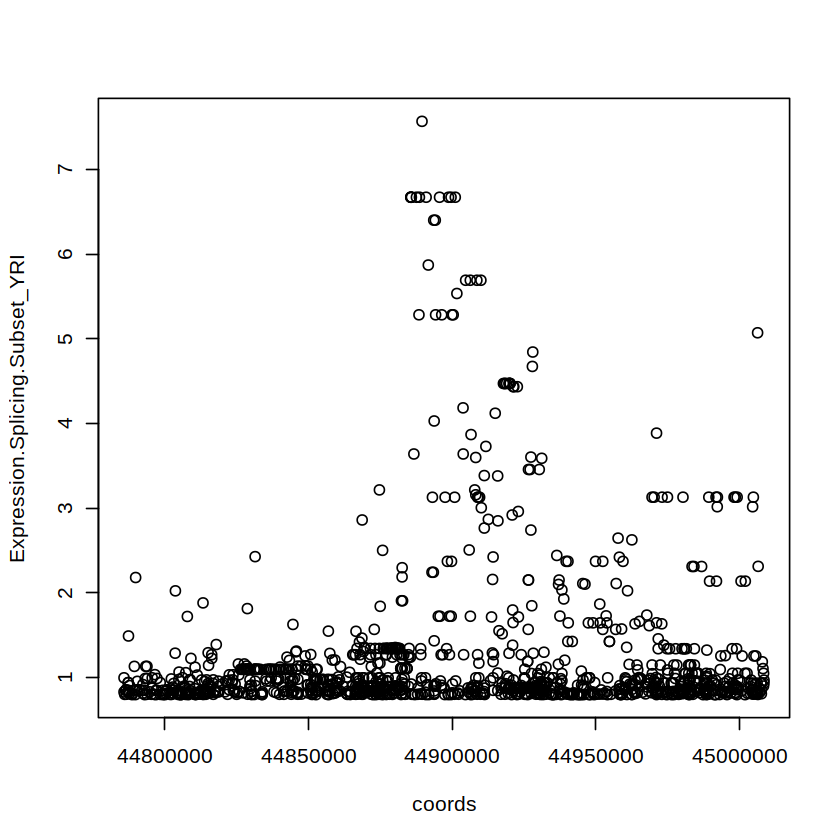

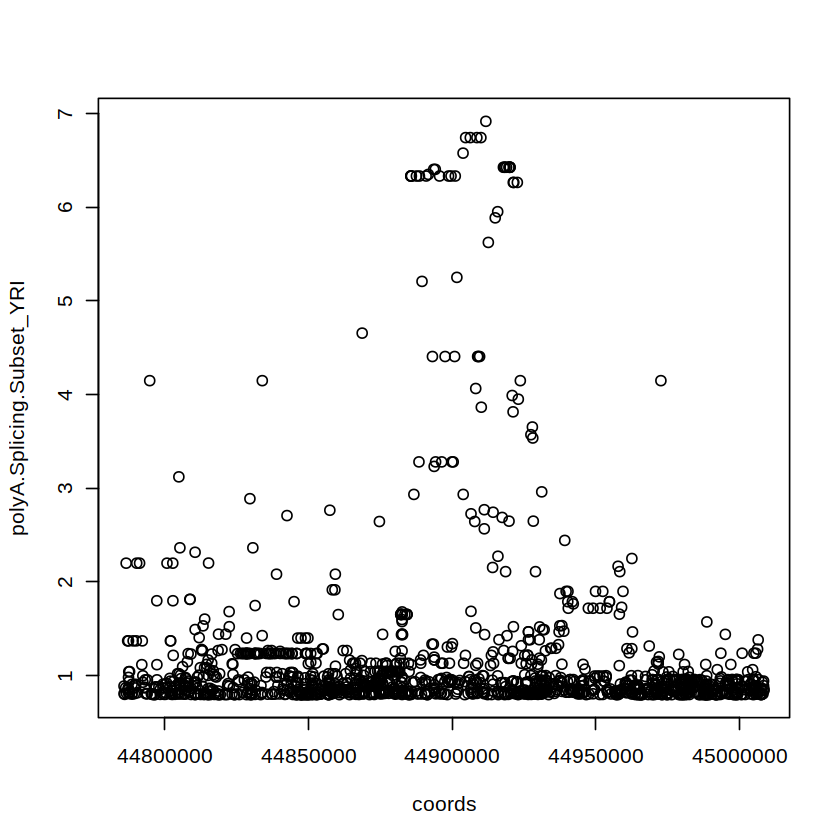

[1] "ENSG00000007341.19"


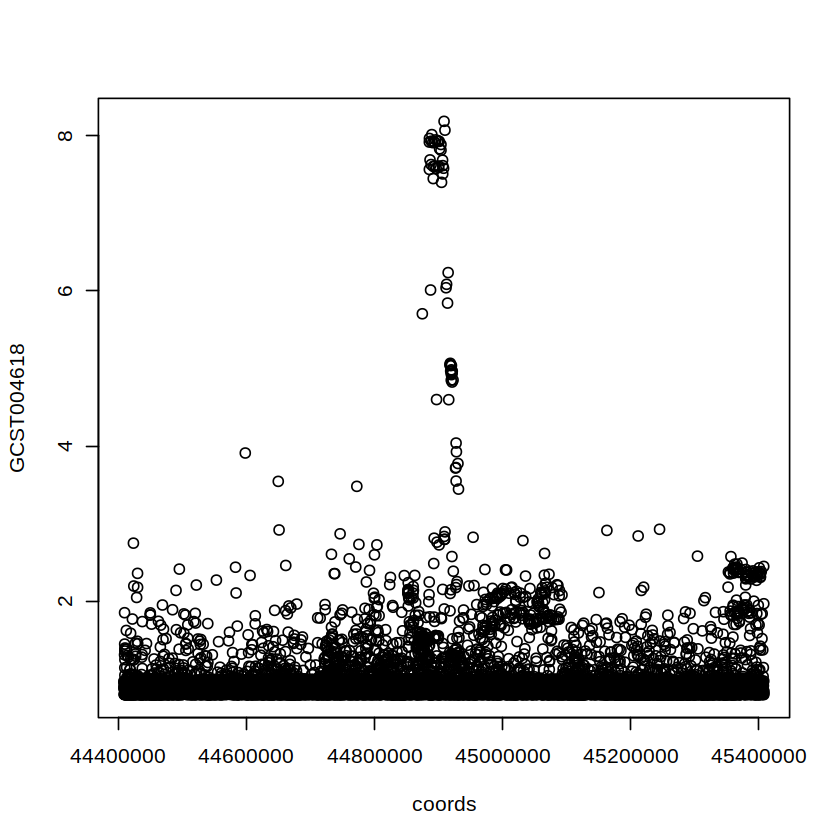

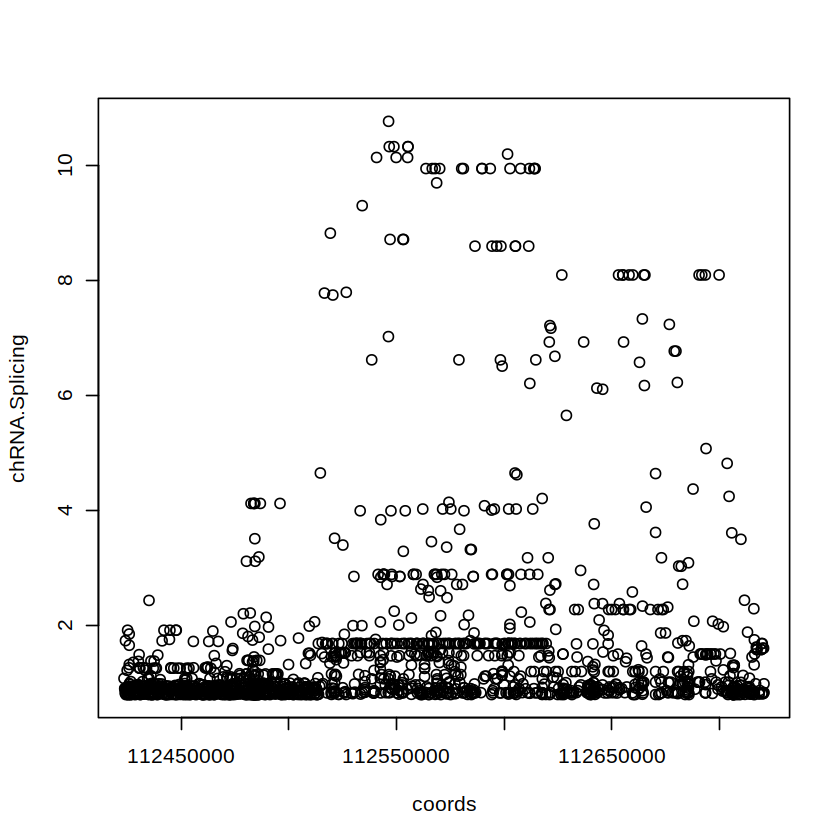

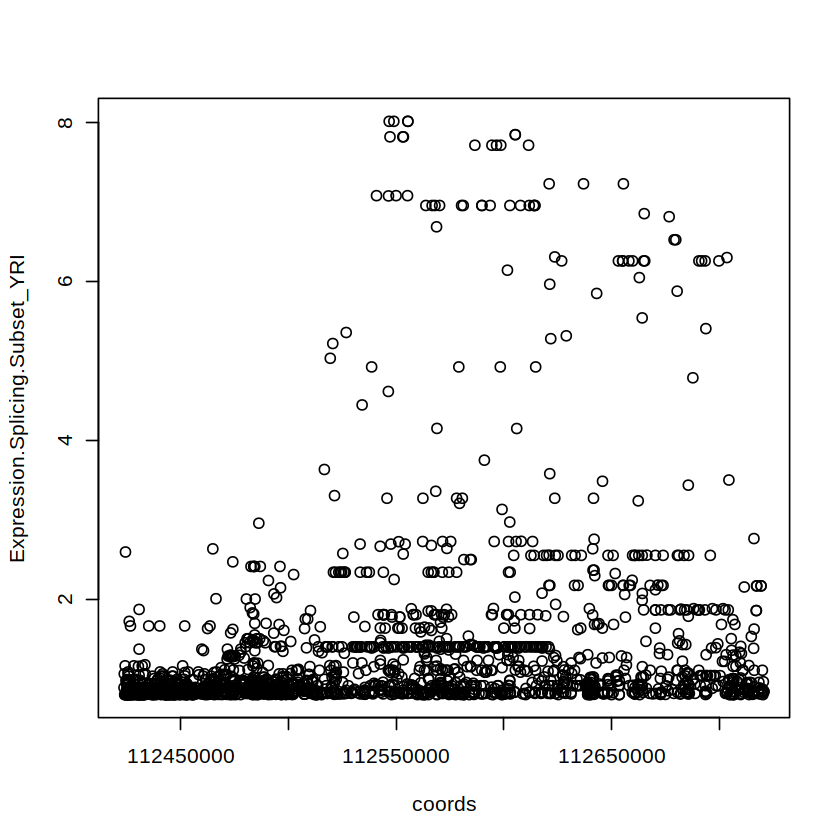

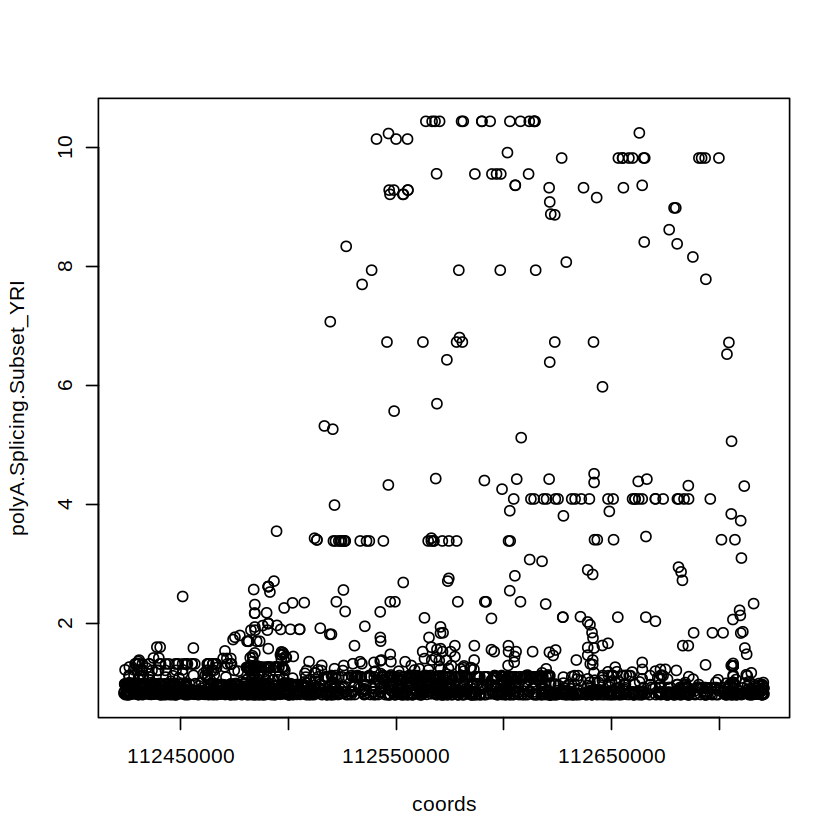

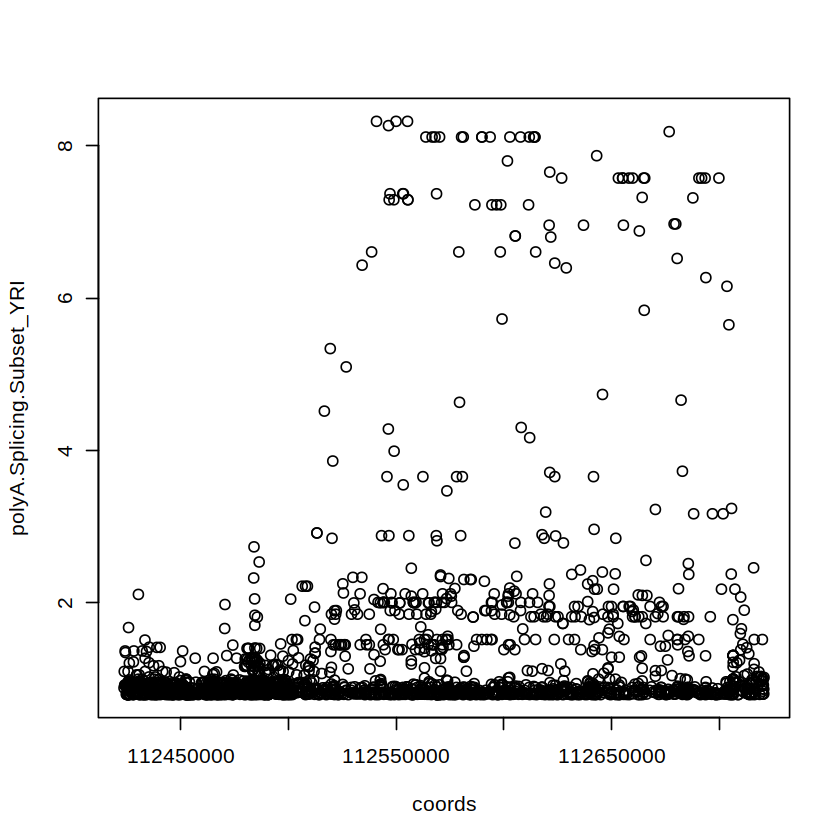

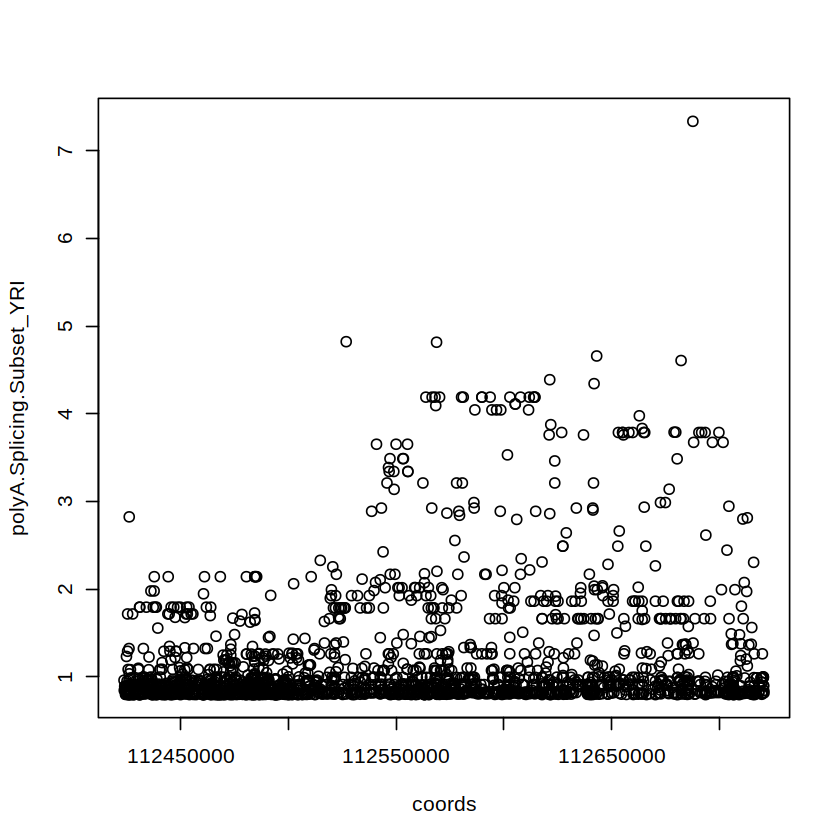

[1] "ENSG00000166532.16"


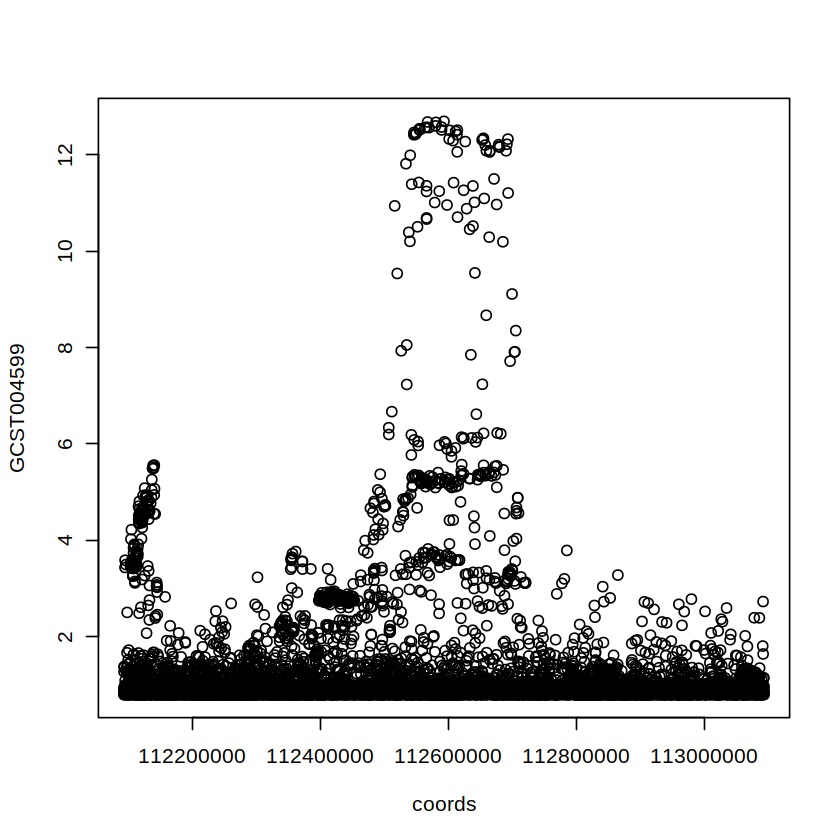

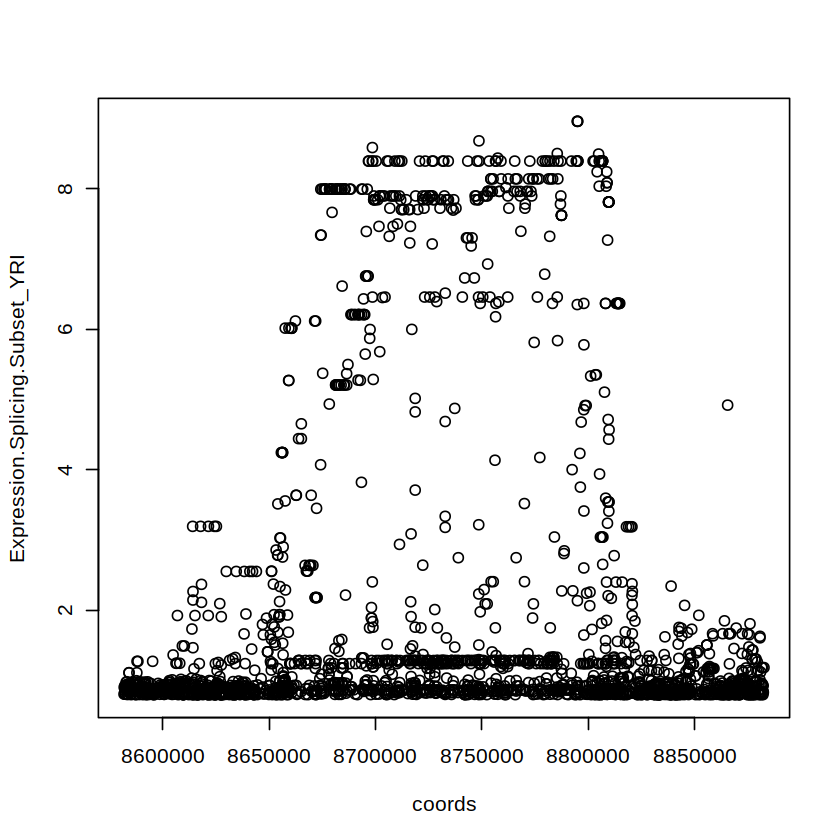

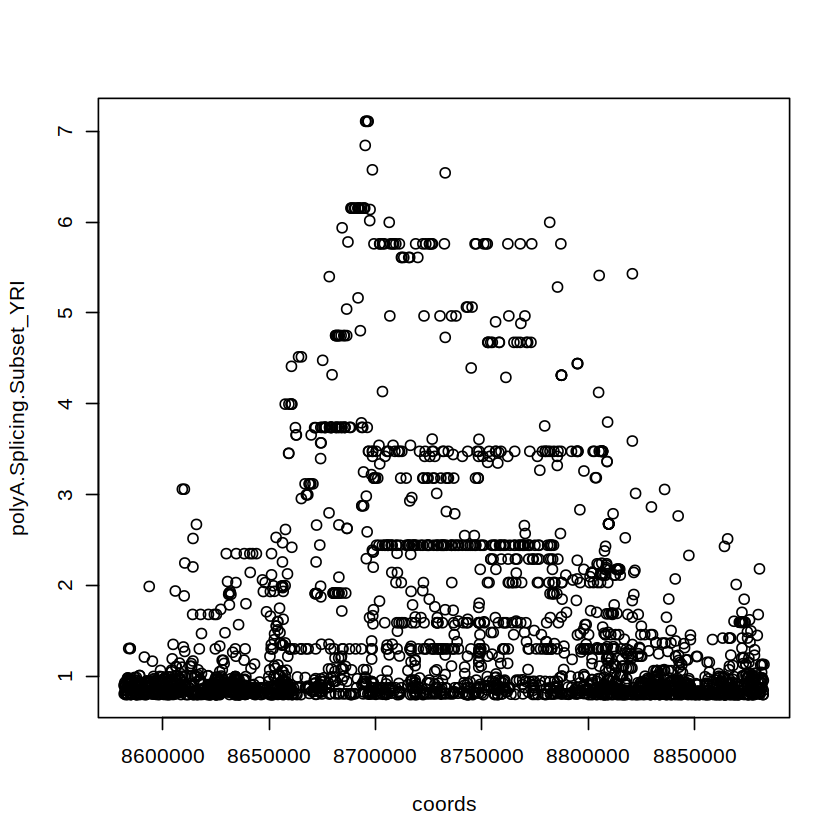

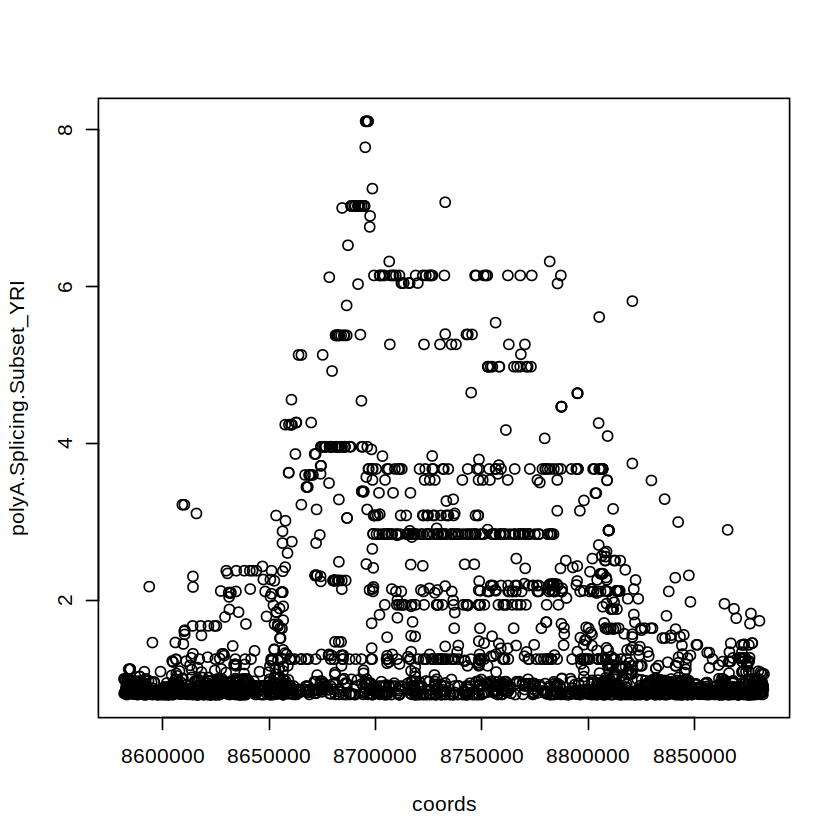

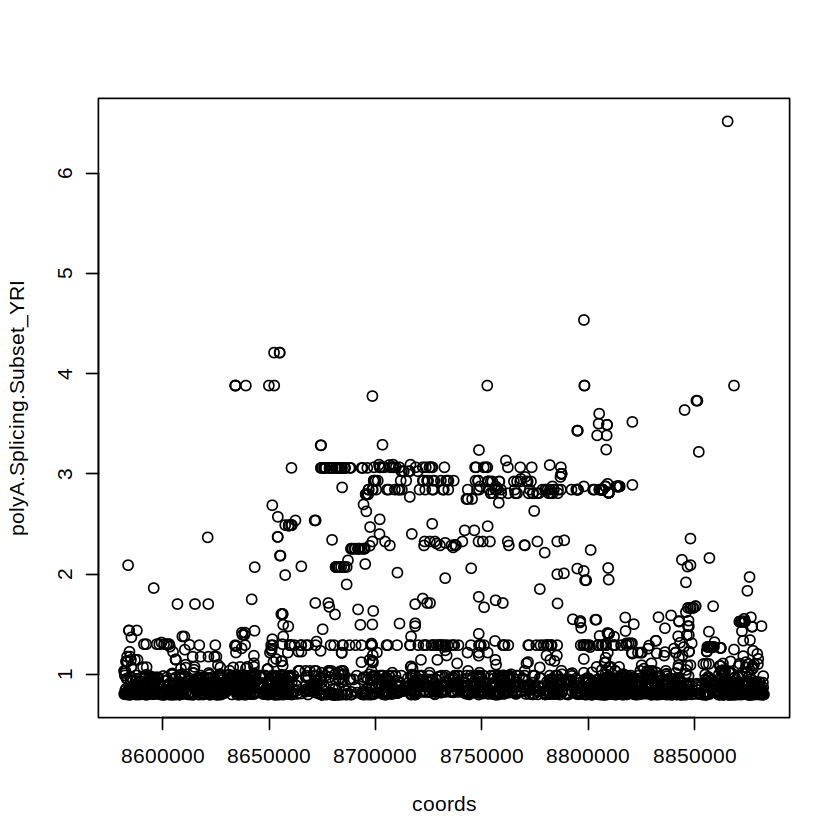

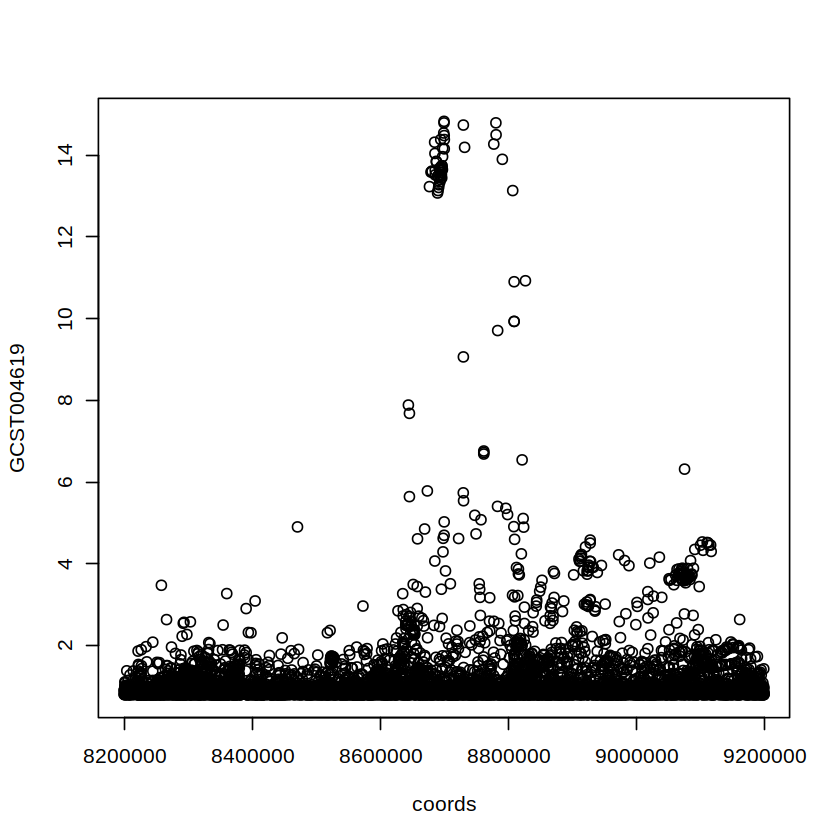

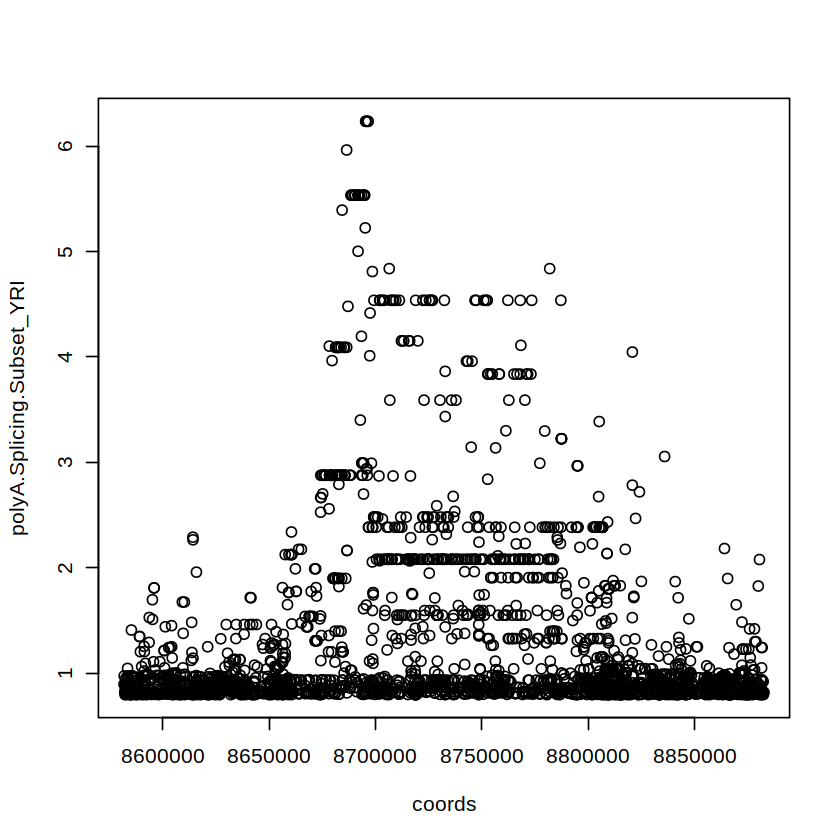

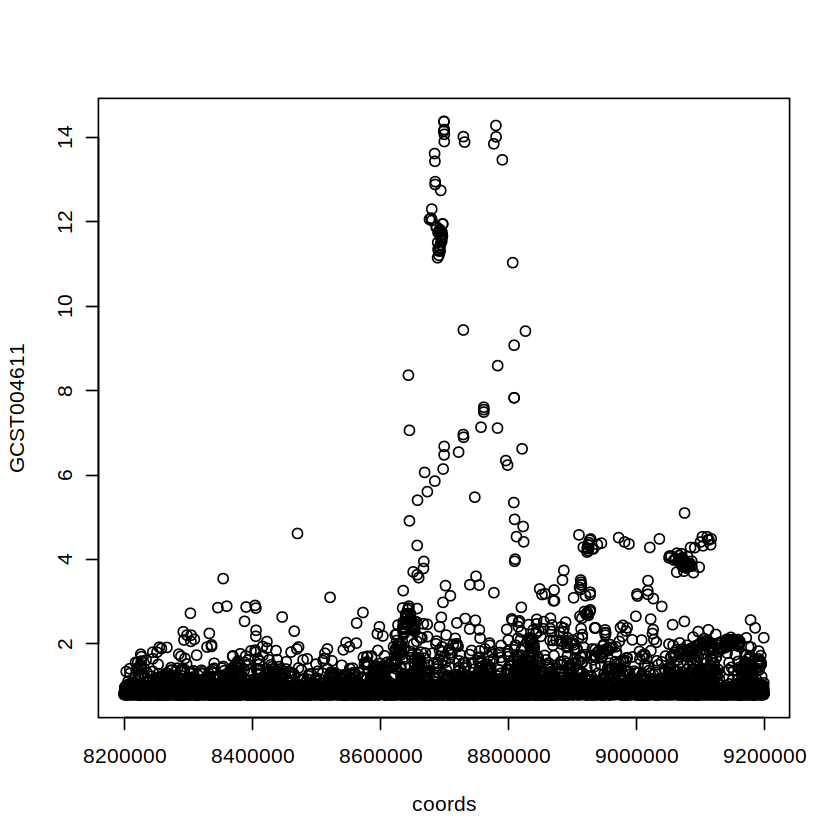

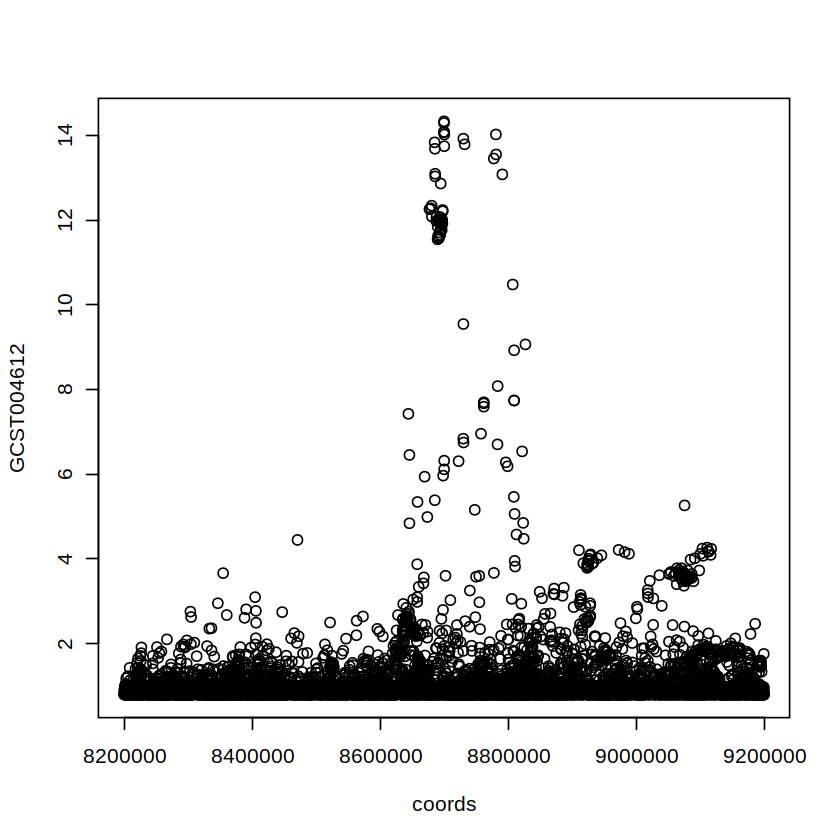

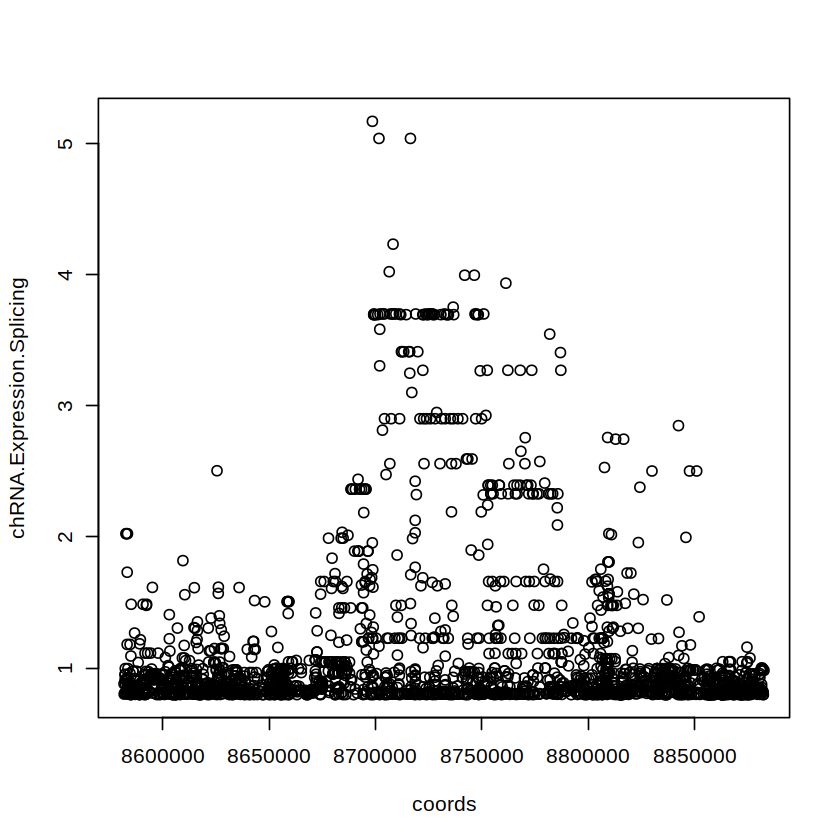

[1] "ENSG00000141295.14"


Warning message in min(x):
"no non-missing arguments to min; returning Inf"
Warning message in max(x):
"no non-missing arguments to max; returning -Inf"
Warning message in min(x):
"no non-missing arguments to min; returning Inf"
Warning message in max(x):
"no non-missing arguments to max; returning -Inf"


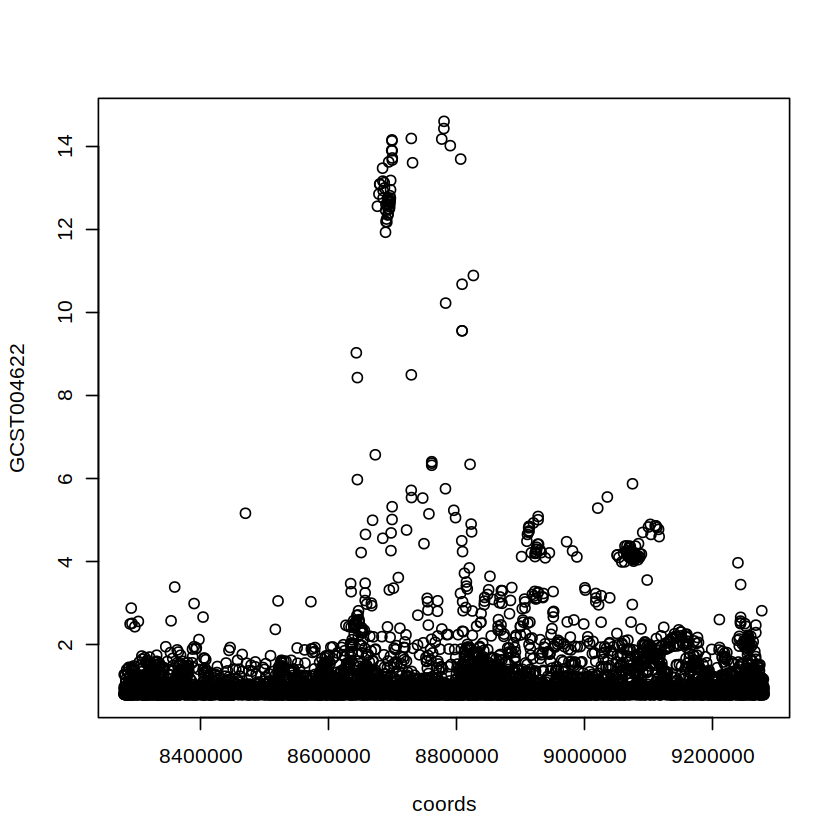

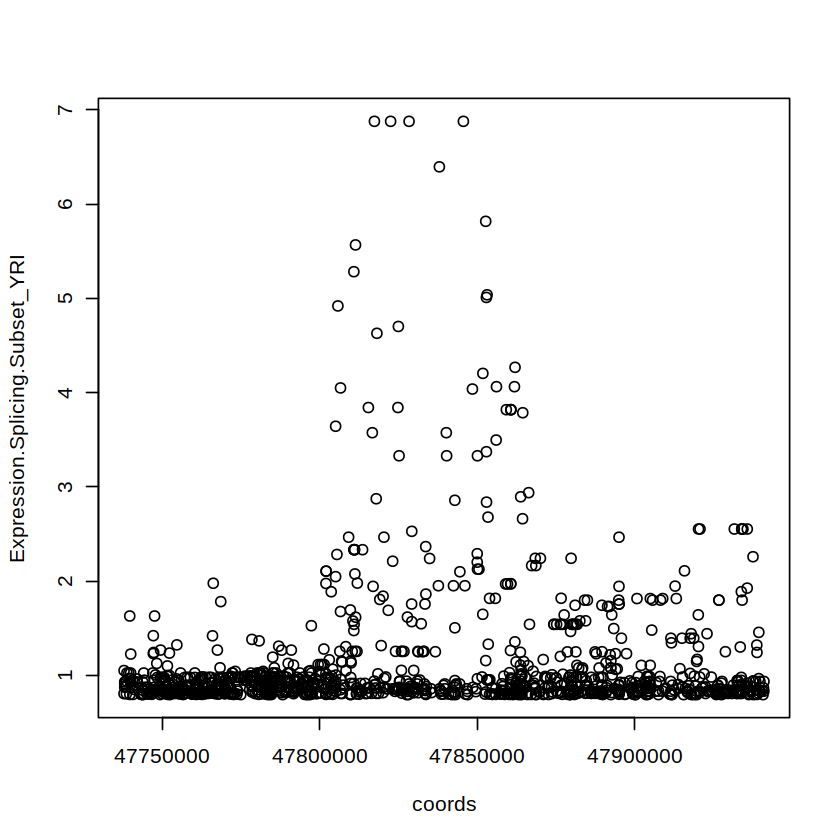

[1] 0
[1] "ENSG00000121417.14"
[1] "ENSG00000077420.16"
[1] "ENSG00000107796.13"


Warning message in min(x):
"no non-missing arguments to min; returning Inf"
Warning message in max(x):
"no non-missing arguments to max; returning -Inf"
Warning message in min(x):
"no non-missing arguments to min; returning Inf"
Warning message in max(x):
"no non-missing arguments to max; returning -Inf"


[1] 0
[1] "ENSG00000082146.13"


Warning message in min(x):
"no non-missing arguments to min; returning Inf"
Warning message in max(x):
"no non-missing arguments to max; returning -Inf"
Warning message in min(x):
"no non-missing arguments to min; returning Inf"
Warning message in max(x):
"no non-missing arguments to max; returning -Inf"


[1] 0


Warning message in min(x):
"no non-missing arguments to min; returning Inf"
Warning message in max(x):
"no non-missing arguments to max; returning -Inf"
Warning message in min(x):
"no non-missing arguments to min; returning Inf"
Warning message in max(x):
"no non-missing arguments to max; returning -Inf"


[1] 0


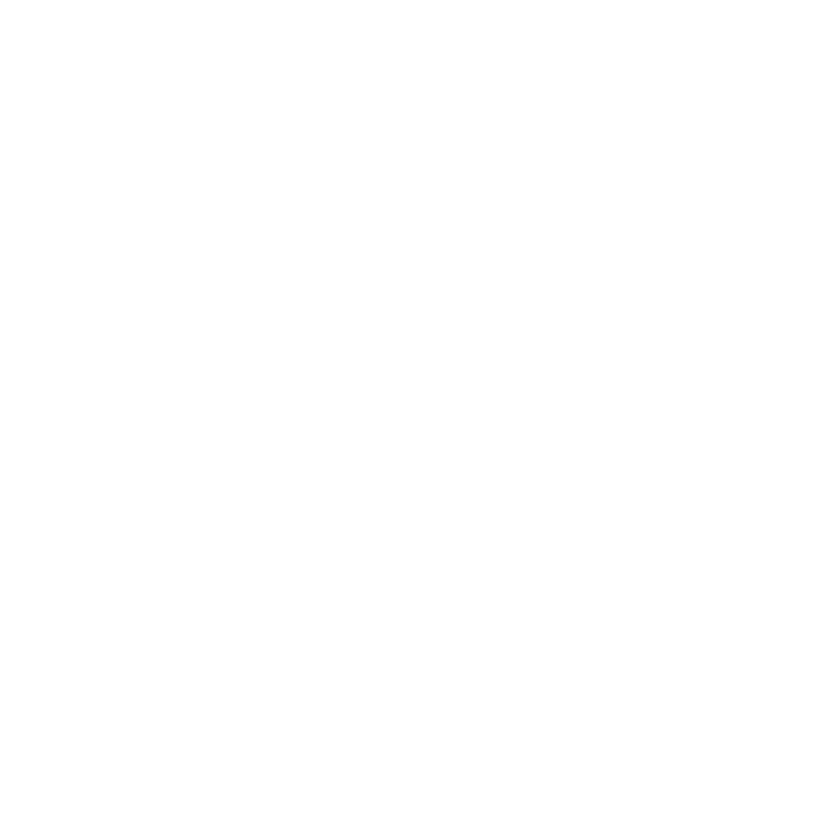

In [102]:
for (gene in gene_list[4:length(gene_list)]){
    print(gene)
    process_slice_gene(colocs_, gene_bed, geneName=gene)
}

In [103]:
gene_list

[1] "ENSG00000114735.9"  "ENSG00000122481.17" "ENSG00000085514.16"
 [4] "ENSG00000183323.13" "ENSG00000183955.13" "ENSG00000166913.13"
 [7] "ENSG00000007341.19" "ENSG00000166532.16" "ENSG00000141295.14"
[10] "ENSG00000121417.14" "ENSG00000077420.16" "ENSG00000107796.13"
[13] "ENSG00000082146.13"

In [105]:
susie <- read_tsv('../code/FineMapping/susie_runs_YRI/susie_output.tab')

In [115]:
susie %>% filter(cs_gene %in% gene_list, cs_names == 'L3')# %>% pull(cs_gene) %>% unique()

cs_gene cs_vars cs_names cs_pip cs_beta cs_beta_se cs_z

In [117]:
susie %>% pull(cs_names) %>% unique()

[1] "L1" "L2" "L3"

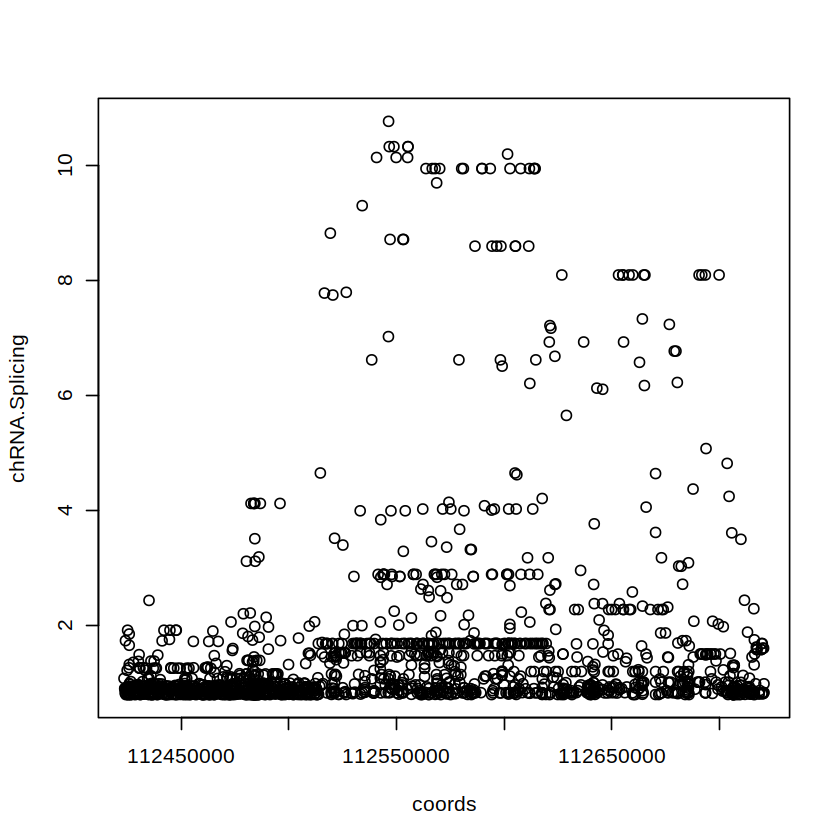

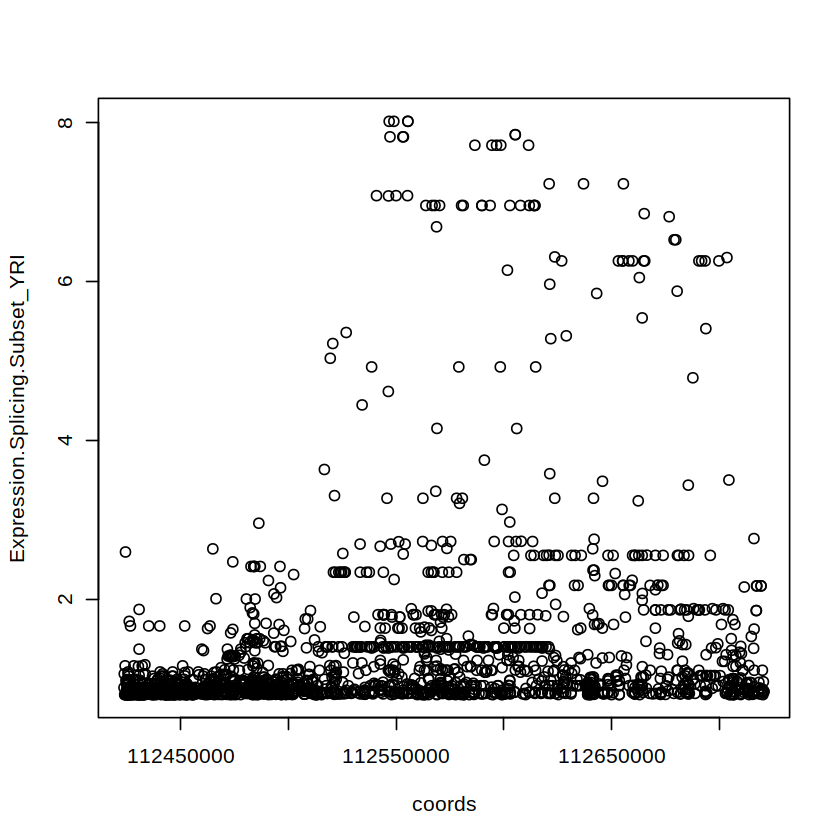

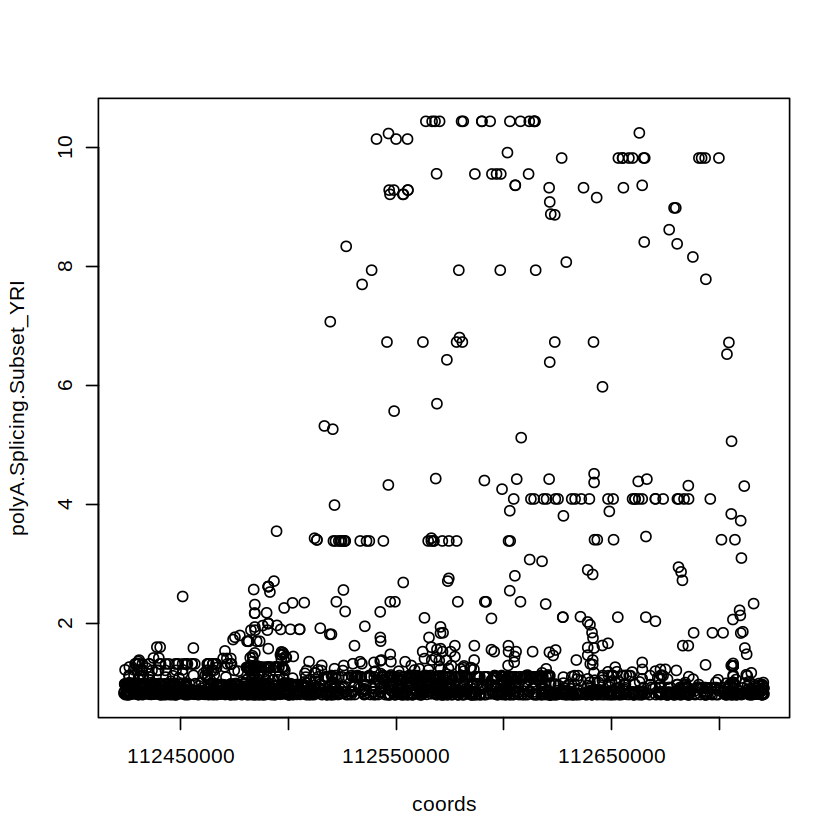

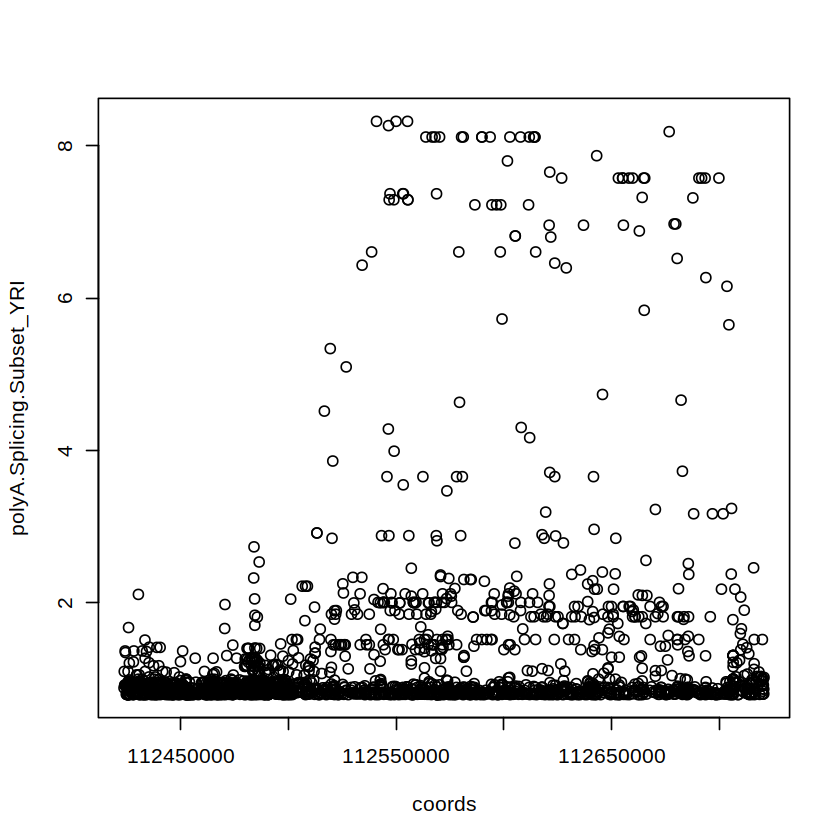

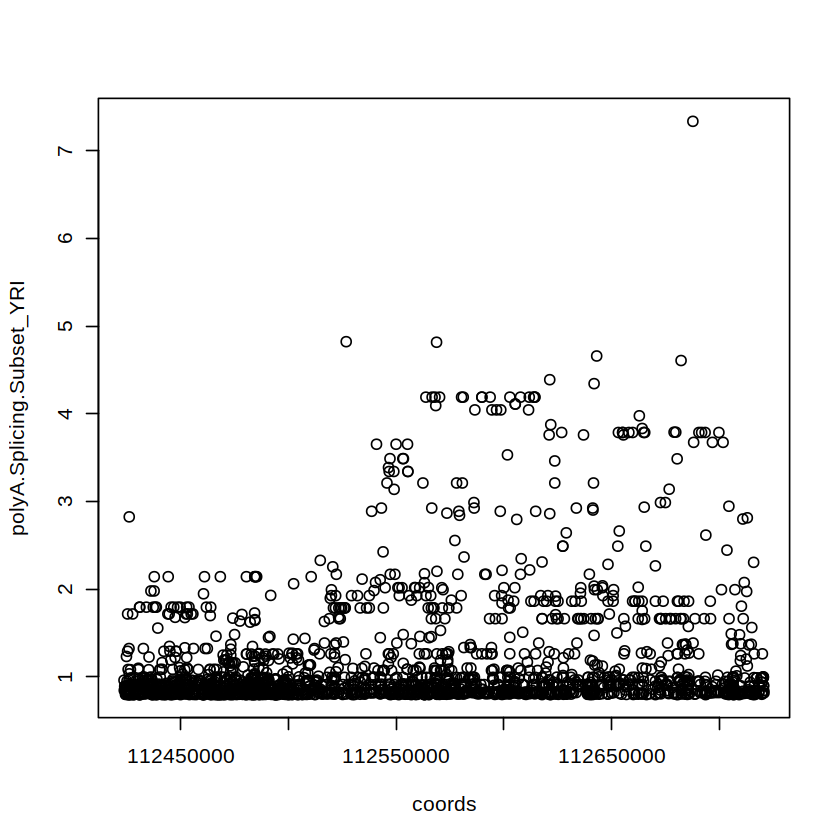

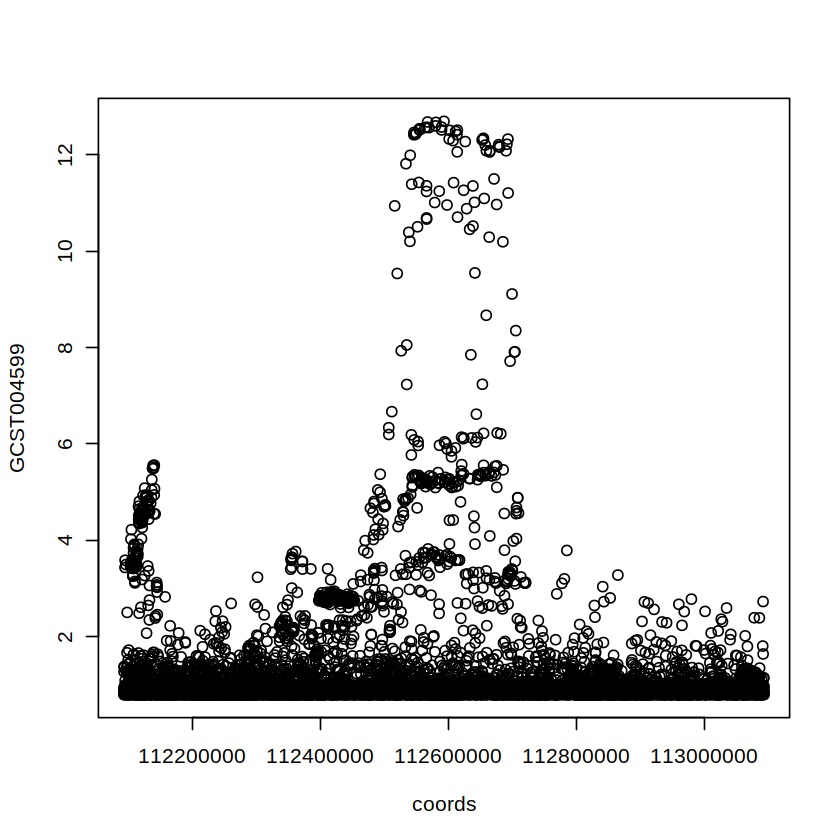

In [109]:
process_slice_gene(colocs_, gene_bed, geneName='ENSG00000007341.19')

In [30]:
x <- get_QTL_df('chRNA.Splicing', "chr7:99367528-101400097", 'ENSG00000077420.16', 
           "chRNA.Splicing;7:100358366:100358933:clu_20457_+")

[1] "chRNA.Splicing"
[1] "chRNA.Splicing;7:100358366:100358933:clu_20457_+"
[1] "chr7:99367528-101400097"
[1] "....."
[1] "/project2/yangili1/bjf79/ChromatinSplicingQTLs/code/QTLs/QTLTools/chRNA.Splicing/NominalPassForColoc.txt.tabix.gz"
[1] "7:100358366:100358933:clu_20457_+:ENSG00000077420.16"


In [ ]:
"chRNA.Expression.Splicing;ENSG00000085514.16"               
"chRNA.Splicing;7:100358366:100358690:clu_20457_+" 

In [50]:
x <- get_QTL_df('chRNA.Splicing', "chr7:99367528-101400097", 'ENSG00000085514.16', 
           "ENSG00000085514.16:ENSG00000085514.16")

[1] "chRNA.Expression.Splicing"
[1] "ENSG00000085514.16:ENSG00000085514.16"
[1] "chr7:99367528-101400097"
[1] "....."
[1] "/project2/yangili1/bjf79/ChromatinSplicingQTLs/code/QTLs/QTLTools/chRNA.Expression.Splicing/NominalPassForColoc.txt.tabix.gz"
[1] "ENSG00000085514.16:ENSG00000085514.16:ENSG00000085514.16"


In [51]:
x

phe_id phe_chr phe_from phe_to phe_strd n_var_in_cis dist_phe_var var_id
     var_chr var_from var_to nom_pval r_squared slope slope_se best_hit

In [71]:
# chRNA.Expression.Splicing;ENSG00000085514.16
QTL_df <- tabix("chr7:99367528-101400097", "/project2/yangili1/bjf79/ChromatinSplicingQTLs/code/QTLs/QTLTools/polyA.Splicing.Subset_YRI/NominalPassForColoc.txt.tabix.gz", check.chr=FALSE, verbose=FALSE)

In [72]:
QTL_df %>% filter(phe_id == '7:100358366:100358690:clu_20457_+:ENSG00000085514.16') #%>% pull(phe_id) %>% gsub('.*:', '', .) %>% unique()

phe_id phe_chr phe_from phe_to phe_strd n_var_in_cis dist_phe_var var_id
     var_chr var_from var_to nom_pval r_squared slope slope_se best_hit

In [65]:
colocs_ %>% filter(Gene == 'ENSG00000077420.16')

ColocCategory    Trait                                                     
1 sQTL+eQTL colocs chRNA.Expression.Splicing;ENSG00000077420.16              
2 sQTL+eQTL colocs Expression.Splicing.Subset_YRI;ENSG00000077420.16         
3 sQTL+eQTL colocs polyA.Splicing.Subset_YRI;10:26437851:26438652:clu_25009_+
4 sQTL+eQTL colocs GWAS;chr10_26451327_GCST004631                            
  PhenotypeClass                 GWAS.Loci                 GWAS.LeadSNP.Chrom
1 chRNA.Expression.Splicing      chr10_26451327_GCST004631 chr10             
2 Expression.Splicing.Subset_YRI chr10_26451327_GCST004631 chr10             
3 polyA.Splicing.Subset_YRI      chr10_26451327_GCST004631 chr10             
4 GWAS                           chr10_26451327_GCST004631 chr10             
  GWAS.LeadSNP.Pos GWAS.accession gwas.trait                        
1 26451327         GCST004631     Basophil percentage of white cells
2 26451327         GCST004631     Basophil percentage of white cells
3 26451327         GCST004631     Basophil percentage of white cells
4 26451327         GCST004631     Basophil percentage of white cells
  TopCandidateSNP  PosteriorColocalizationPr Trait_name                      
1 10:26437223:AT:A 0.8587                    ENSG00000077420.16              
2 10:26437223:AT:A 0.8587                    ENSG00000077420.16              
3 10:26437223:AT:A 0.8587                    10:26437851:26438652:clu_25009_+
4 10:26437223:AT:A 0.8587                    chr10_26451327_GCST004631       
  Gene              
1 ENSG00000077420.16
2 ENSG00000077420.16
3 ENSG00000077420.16
4 ENSG00000077420.16

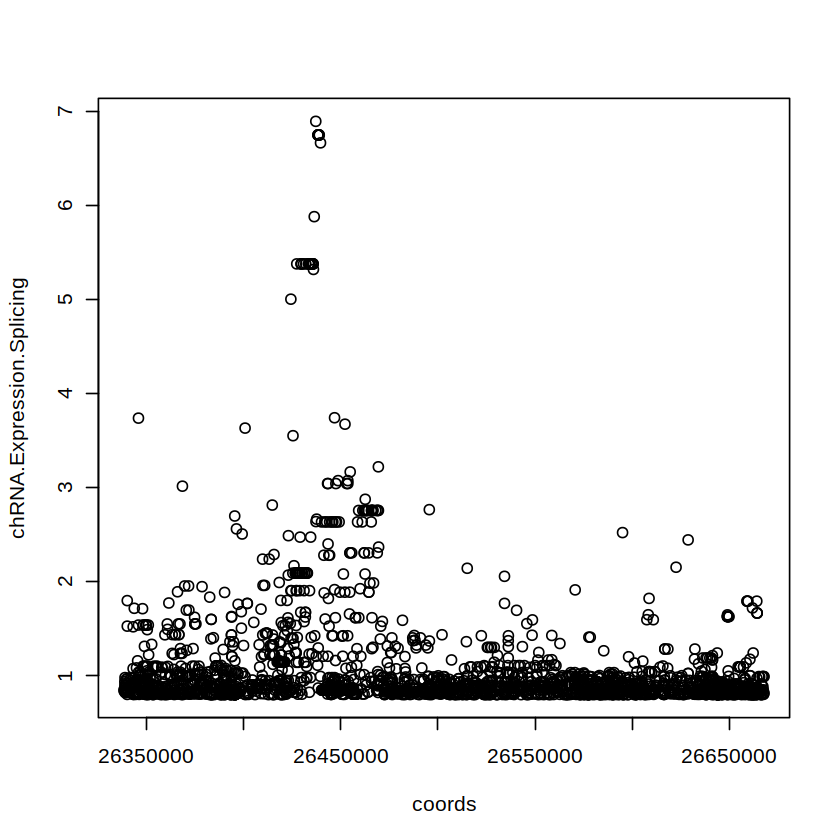

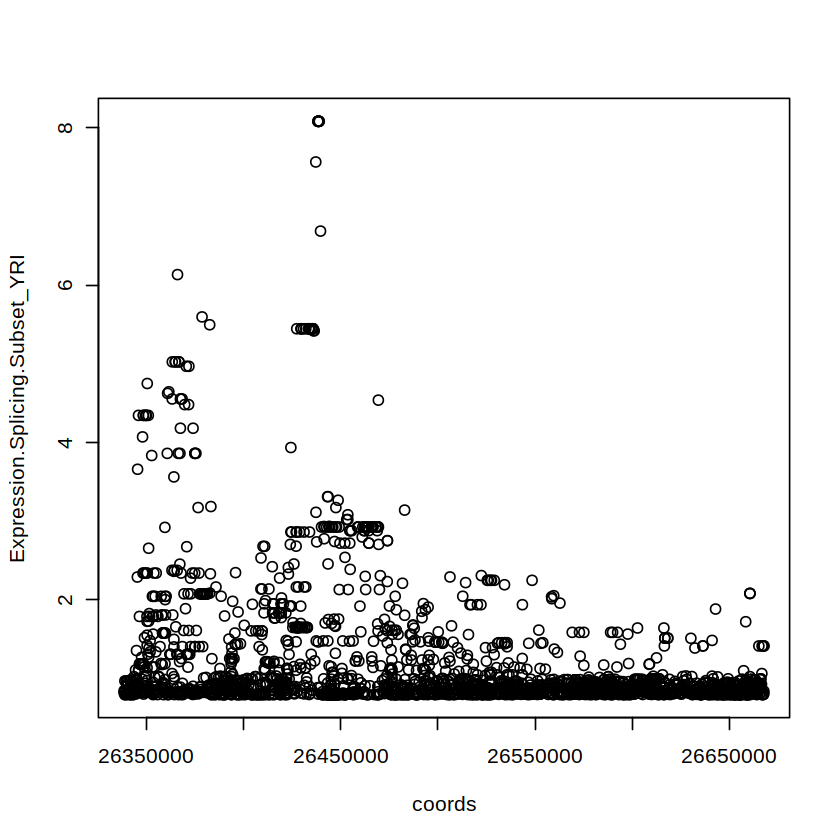

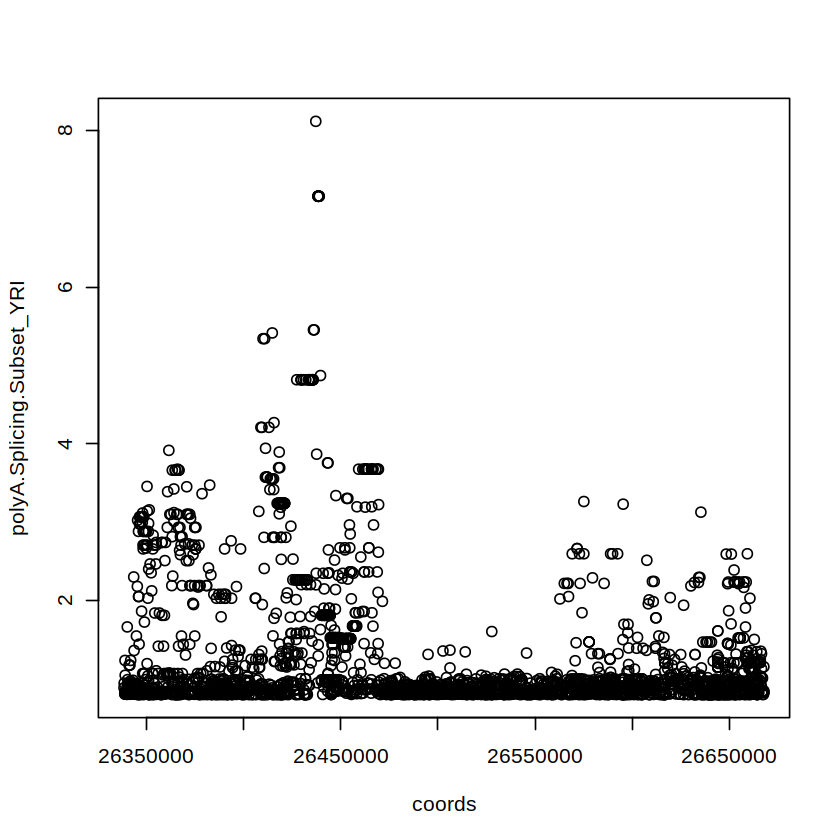

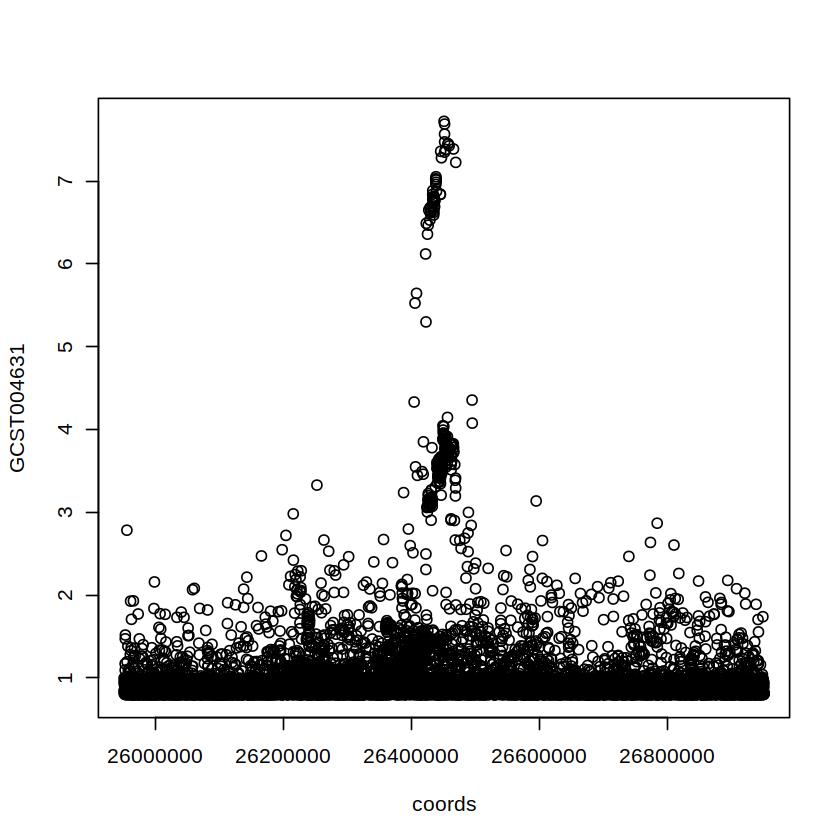

In [80]:
process_slice_gene(colocs_, gene_bed, geneName='ENSG00000077420.16')

[1]  3 12
[1] "ENSG00000114735.9"


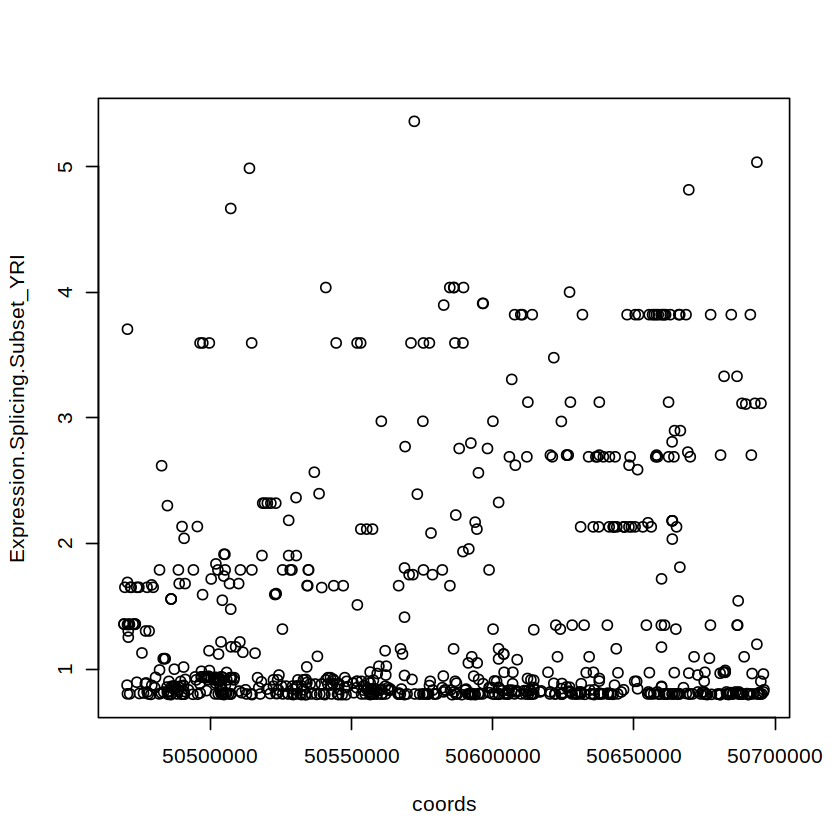

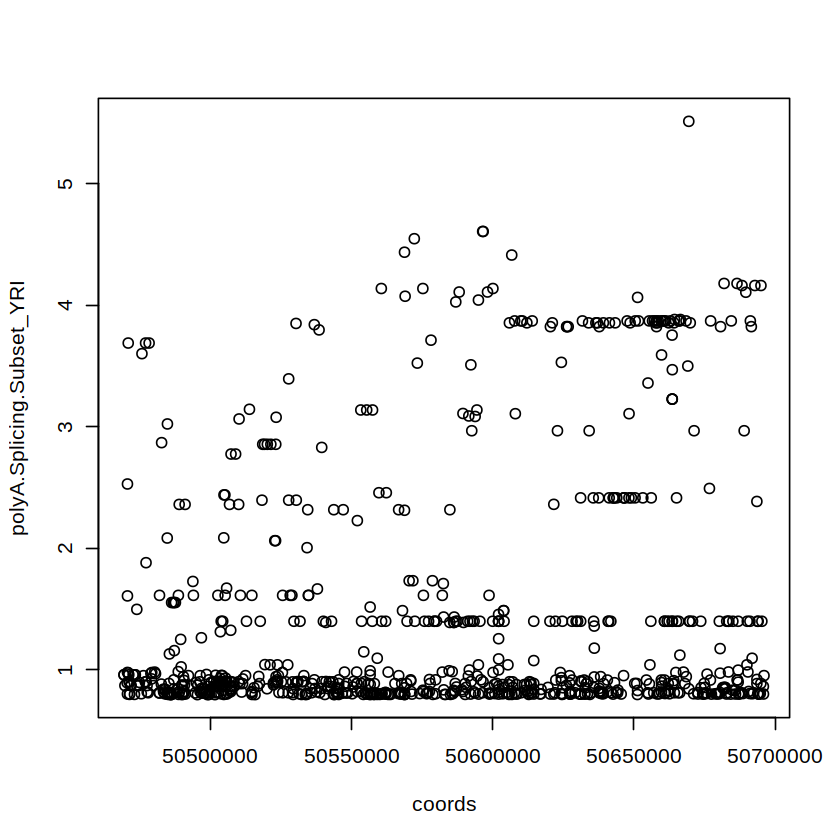

[1]  5 12
[1] "ENSG00000122481.17"


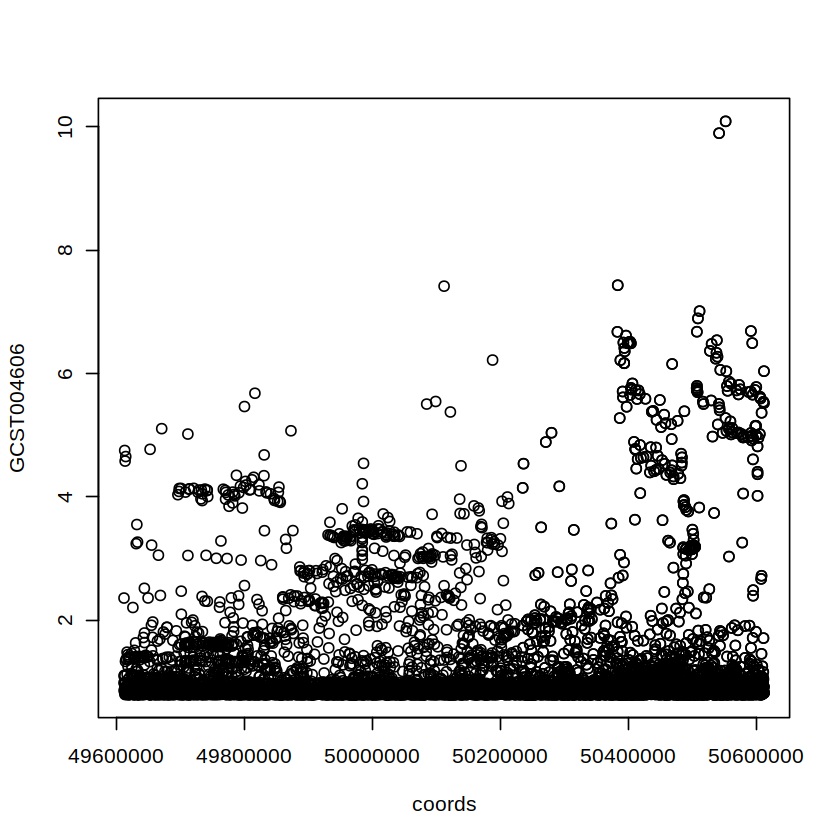

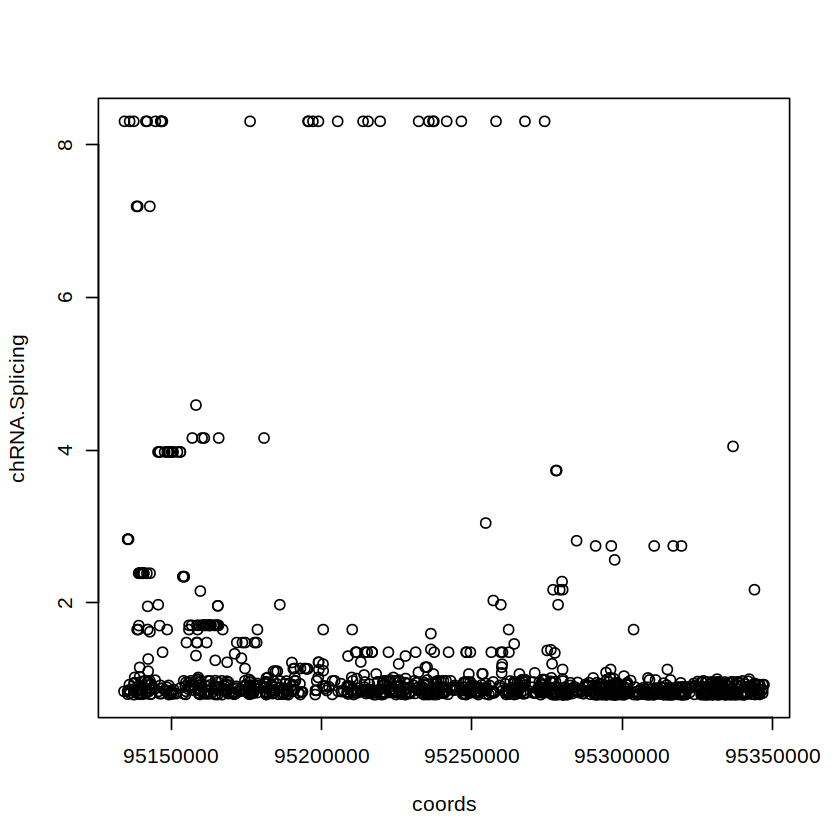

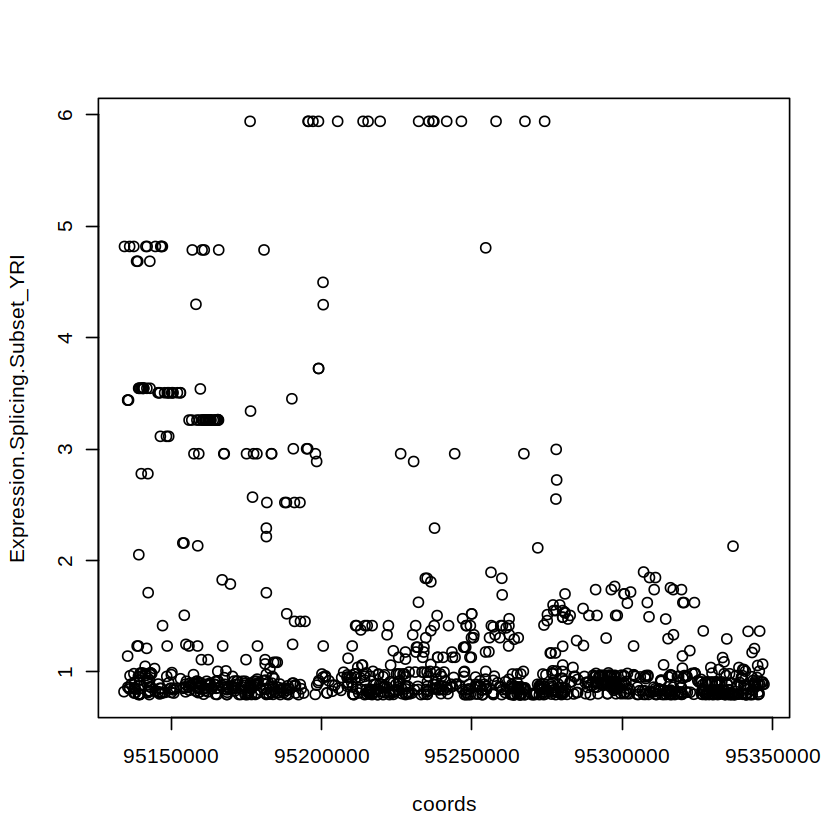

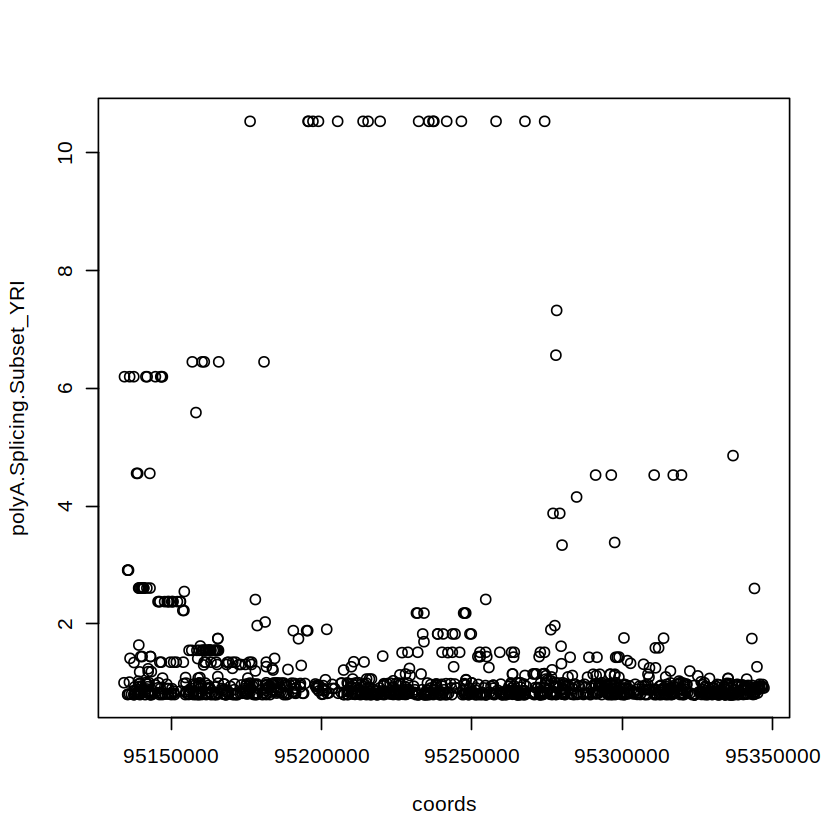

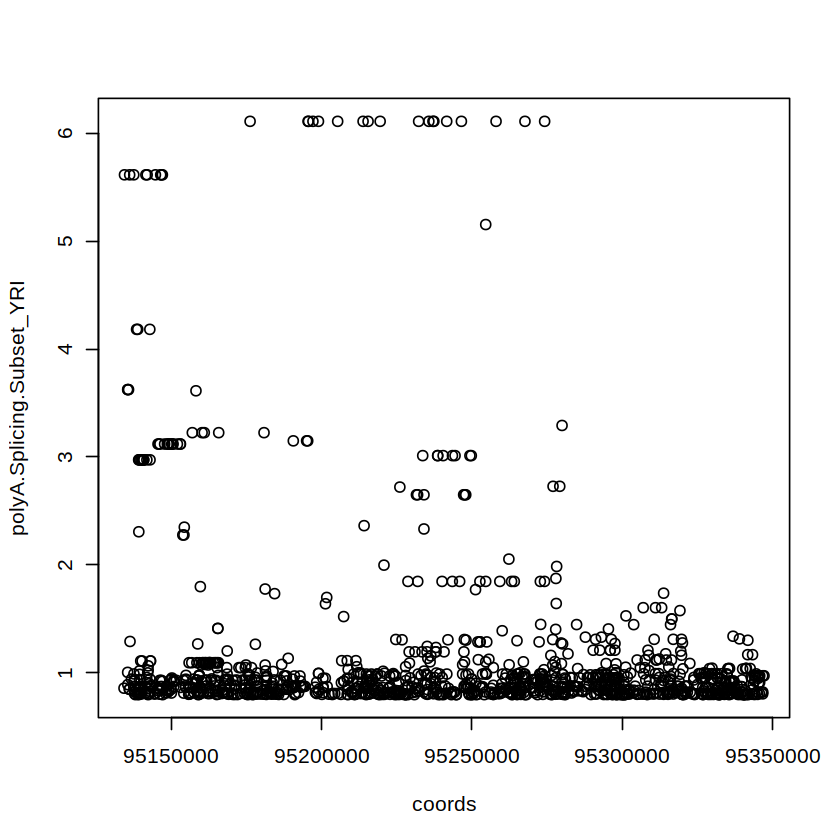

[1] 12 12
[1] "ENSG00000085514.16"


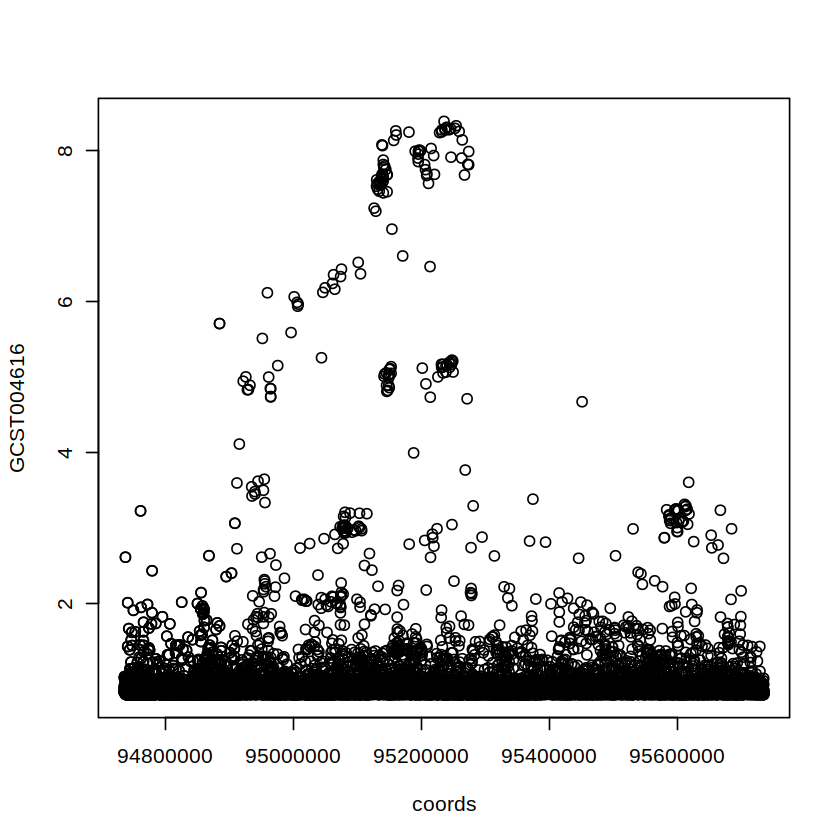

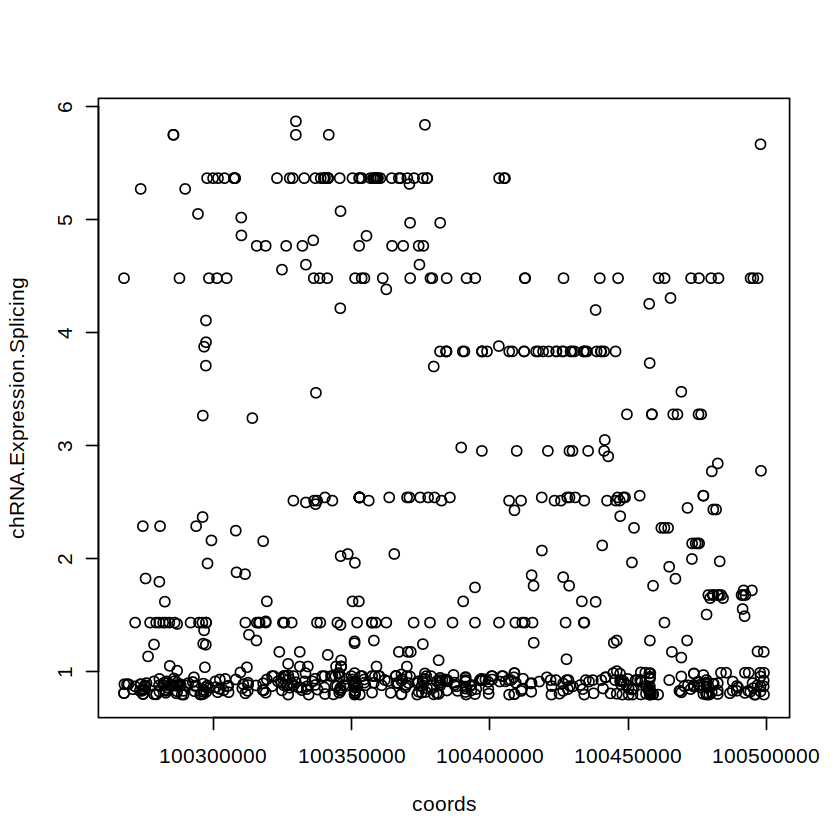

[1] 0
[1] 0
[1] 0
[1]  4 12
[1] "ENSG00000121716.20"
[1] 36 12
[1] "ENSG00000183323.13"


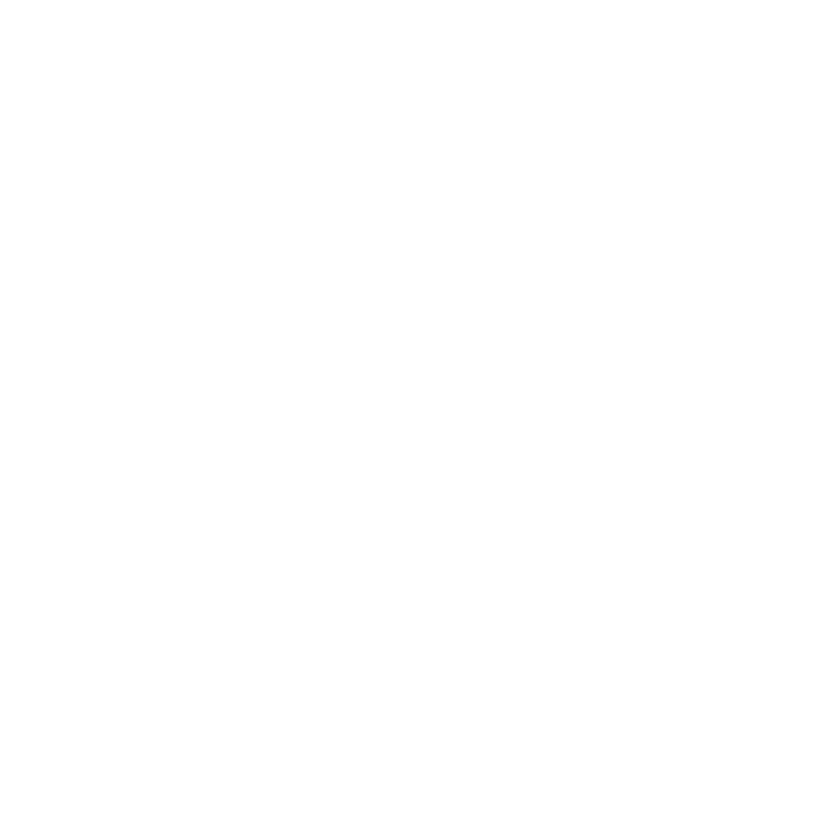

In [112]:
for(gene in gene_list){
    process_slice_gene(colocs_, gene_bed, geneName=gene)
}

# Finemapping

In [138]:
library(dplyr)
library(tidyverse)
library(data.table)
library(susieR)
set.seed(0)

# nominal <- read.table(nominal, sep=' ', header=TRUE)
# perm <- read.table(perm, sep=' ', header=TRUE)

run_susie <- function(nominal.gene, gene, header, genotype) {
  
    # Get variants positions
    chrom <- nominal.gene$phe_chr[1] %>% as.character() %>% substr(4, 5)
    var_from <- nominal.gene$var_from[1] %>% as.character()
    var_to <- tail(nominal.gene$var_from, n=1) %>% as.character()
    position = paste0(chrom, ':', var_from, '-', var_to)
    
    # Get genotypes of region
    
    tabix_cmd <- paste("tabix", genotype, position)
        
    GT <- fread(cmd = str_glue(tabix_cmd),
                  data.table = F, header = F)
    
    colnames(GT) <- header
    
    X <- GT %>% filter(ID %in% nominal.gene$var_id)
    XCor <- cor(t(X[,colnames(X[6:dim(GT)[2]])]))
    XCor[is.na(XCor)] = 0
    
    Z <- (nominal.gene$slope / nominal.gene$slope_se)
    
    n <- dim(GT)[2] - 6
    
    tryCatch({
        susie_out <- susie_rss(Z, XCor, L=3, n=n)
    } , error = function(e){
        susie_out <- susie_rss(Z, XCor, L=3, n=n, estimate_prior_variance = FALSE)
    }
    )
    
    return(susie_out)
}

head_cmd <- paste("zcat", "../code/FineMapping/Genotypes/1KG_GRCh38/YRI.txt.bgz", "| head")

genotype <- "../code/FineMapping/Genotypes/1KG_GRCh38/YRI.txt.bgz"

header <- fread(cmd = str_glue(head_cmd),
                  data.table = F, header = T) %>% colnames()

# genes <- perm[perm$q <= 1e-1, ]$phe_id


In [130]:
# nominal.gene

coords <- 'chr1:110546384-114546384'

assay_file <- paste0(dir, 'code/QTLs/QTLTools/Expression.Splicing.Subset_YRI/NominalPassForColoc.txt.tabix.gz')

# tabix_cmd <- paste("tabix", genotype, position)

nominal.slice <- tabix(coords, assay_file, check.chr=FALSE, verbose=FALSE)


# QTL_df <- tabix(coords, assay_file, check.chr=FALSE, verbose=FALSE) %>%
#         filter(phe_id == phenotype_id)
#     return (QTL_df)

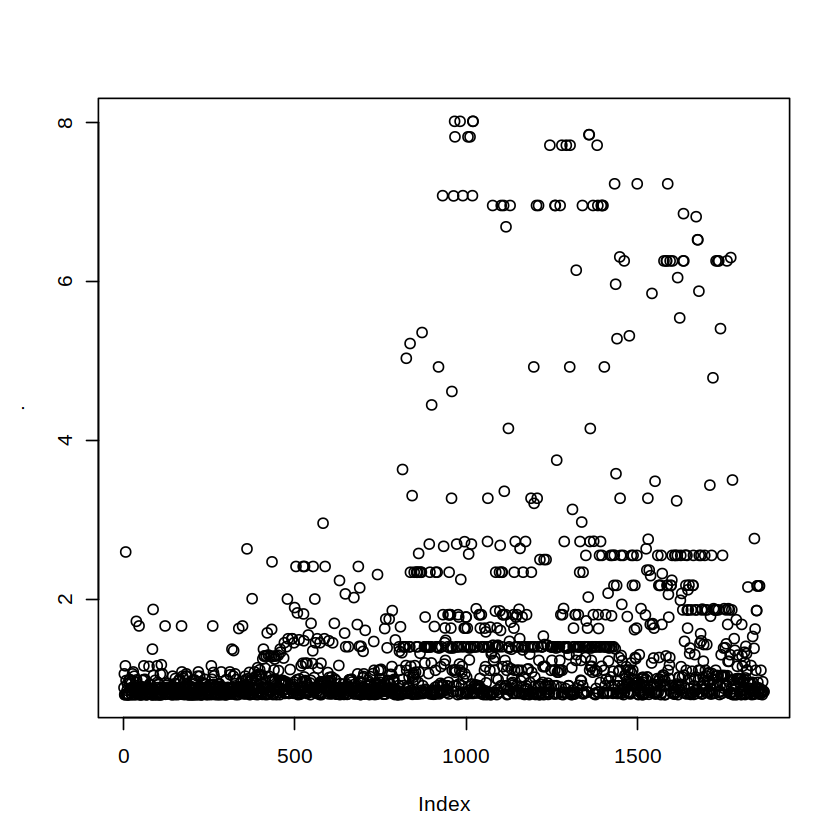

In [136]:
nominal.slice %>% filter(phe_id == 'ENSG00000007341.19:ENSG00000007341.19') %>% pull(nom_pval) %>% 
as.numeric() %>% -log10(.) %>% plot(.)

In [ ]:
tabix_cmd <- paste("tabix", genotype, position)
        
    GT <- fread(cmd = str_glue(tabix_cmd),
                  data.table = F, header = F)

In [142]:
GT <- tabix('1:110546384-114546384', genotype, check.chr=FALSE, verbose=TRUE)

TABIX-QUERY
 * Processing input (1): 
CONVERT TO BED
 * Checking input type... PASS
   Input is in index format
VALIDATE REGIONS
 * Check if index is a string... PASS
 * Check index pattern... PASS
 * Check for missing values... PASS
 * Check for larger start position... PASS.
 * Check if zero based... PASS
 * Checking sort order... PASS
 * Checking for overlapping 'contiguous' regions... FAIL
   The input for object has overlapping features!
   This can cause unexpected results for some set operations.
   i.e. x <- bedr.merge.region(x)

bash -c 'tabix  ../code/FineMapping/Genotypes/1KG_GRCh38/YRI.txt.bgz -R /tmp//RtmpD7wuPJ/_175b762828ac96.bed '


In [143]:
GT

CHROM  POS       ID                    REF     FORMAT NA18489 NA18511
1      1      110546397 1:110546397:A:T       A       GT     0       2      
2      1      110546407 1:110546407:C:G       C       GT     0       0      
3      1      110546617 1:110546617:C:T       C       GT     0       0      
4      1      110546783 1:110546783:C:T       C       GT     0       0      
5      1      110546984 1:110546984:G:A       G       GT     0       0      
6      1      110547009 1:110547009:G:A       G       GT     0       0      
7      1      110547020 1:110547020:A:T       A       GT     0       0      
8      1      110547048 1:110547048:G:A       G       GT     0       0      
9      1      110547145 1:110547145:T:G       T       GT     0       2      
10     1      110547159 1:110547159:C:A       C       GT     0       0      
11     1      110547215 1:110547215:T:C       T       GT     0       2      
12     1      110547233 1:110547233:C:T       C       GT     0       0      
13     1      110547496 1:110547496:G:A       G       GT     0       2      
14     1      110547511 1:110547511:A:G       A       GT     0       0      
15     1      110547639 1:110547639:G:A       G       GT     0       0      
16     1      110547696 1:110547696:G:A       G       GT     0       0      
17     1      110547697 1:110547697:CATT:C    CATT    GT     0       0      
18     1      110547826 1:110547826:C:T       C       GT     0       0      
19     1      110548050 1:110548050:C:T       C       GT     0       0      
20     1      110548207 1:110548207:A:C       A       GT     0       0      
21     1      110548224 1:110548224:G:A       G       GT     0       0      
22     1      110548298 1:110548298:C:T       C       GT     0       2      
23     1      110548315 1:110548315:C:T       C       GT     0       0      
24     1      110548321 1:110548321:G:A       G       GT     0       0      
25     1      110548622 1:110548622:CATGTTG:C CATGTTG GT     0       0      
26     1      110548770 1:110548770:C:T       C       GT     0       0      
27     1      110548771 1:110548771:G:A       G       GT     0       2      
28     1      110548823 1:110548823:T:A       T       GT     0       2      
29     1      110548926 1:110548926:A:G       A       GT     0       0      
30     1      110548962 1:110548962:C:T       C       GT     0       0      
<U+22EE> <U+22EE> <U+22EE>  <U+22EE>              <U+22EE> <U+22EE> <U+22EE> <U+22EE>
23777  1      114539492 1:114539492:G:T       G       GT     2       0      
23778  1      114539859 1:114539859:A:C       A       GT     0       0      
23779  1      114540572 1:114540572:T:C       T       GT     0       0      
23780  1      114540898 1:114540898:G:C       G       GT     0       0      
23781  1      114541024 1:114541024:C:T       C       GT     0       0      
23782  1      114541060 1:114541060:T:C       T       GT     0       1      
23783  1      114541175 1:114541175:G:A       G       GT     0       0      
23784  1      114541220 1:114541220:G:A       G       GT     0       1      
23785  1      114541337 1:114541337:C:T       C       GT     0       0      
23786  1      114541920 1:114541921:GA:G      GA      GT     2       1      
23787  1      114541920 1:114541923:GAA:G     GAA     GT     0       0      
23788  1      114542175 1:114542175:C:T       C       GT     0       1      
23789  1      114542227 1:114542227:GA:G      GA      GT     0       0      
23790  1      114542439 1:114542439:C:T       C       GT     0       0      
23791  1      114543330 1:114543330:G:A       G       GT     0       0      
23792  1      114543445 1:114543445:C:T       C       GT     0       1      
23793  1      114543492 1:114543492:T:C       T       GT     0       0      
23794  1      114543512 1:114543512:G:C       G       GT     0       0      
23795  1      114543534 1:114543534:T:TA      T       GT     0       1      
23796  1      114543611 1:114543611:T:C       T       GT     0       0 

In [122]:
nominal.gene <- nominal %>% filter(phe_id == gene)
    
susie_out <- run_susie(nominal.gene, gene, header, genotype)

[1] "#CHROM"  "POS"     "ID"      "REF"     "FORMAT"  "NA18489" "NA18511"
 [8] "NA18908" "NA18910" "NA18934" "NA18488" "NA18508" "NA18510" "NA19095"
[15] "NA19153" "NA19160" "NA19172" "NA19184" "NA19189" "NA18868" "NA18870"
[22] "NA19204" "NA19209" "NA19099" "NA19222" "NA18907" "NA18933" "NA19223"
[29] "NA19235" "NA19247" "NA19108" "NA19141" "NA19152" "NA19146" "NA19171"
[36] "NA19190" "NA19210" "NA19102" "NA19107" "NA19114" "NA19119" "NA19121"
[43] "NA19138" "NA18916" "NA18923" "NA19096" "NA18505" "NA18517" "NA19116"
[50] "NA19130" "NA19147" "NA19159" "NA18858" "NA18909" "NA19248" "NA19093"
[57] "NA19098" "NA18487" "NA18499" "NA18502" "NA19185" "NA19197" "NA18519"
[64] "NA19200" "NA19236" "NA19113" "NA19118" "NA19137" "NA19144" "NA19149"
[71] "NA19175" "NA19207" "NA19214" "NA18867" "NA19257" "NA18486" "NA18498"
[78] "NA18520" "NA19092" "NA18912" "NA18917" "NA18861" "NA18873" "NA19256"
[85] "NA19198" "NA19201" "NA19206" "NA19213" "NA19225" "NA19117" "NA19129"
[92] "NA19131" "NA19143" "NA19150"

In [125]:
colocs_[colocs_$Gene == 'ENSG00000007341.19',]

ColocCategory    Trait                                                     
1 sQTL+eQTL colocs chRNA.Splicing;1:112526111:112541951:clu_1285_-           
2 sQTL+eQTL colocs Expression.Splicing.Subset_YRI;ENSG00000007341.19         
3 sQTL+eQTL colocs polyA.Splicing.Subset_YRI;1:112526111:112540779:clu_1285_-
4 sQTL+eQTL colocs polyA.Splicing.Subset_YRI;1:112526111:112541951:clu_1285_-
5 sQTL+eQTL colocs polyA.Splicing.Subset_YRI;1:112598086:112610841:clu_1287_-
6 sQTL+eQTL colocs GWAS;chr1_112593607_GCST004599                            
  PhenotypeClass                 GWAS.Loci                 GWAS.LeadSNP.Chrom
1 chRNA.Splicing                 chr1_112593607_GCST004599 chr1              
2 Expression.Splicing.Subset_YRI chr1_112593607_GCST004599 chr1              
3 polyA.Splicing.Subset_YRI      chr1_112593607_GCST004599 chr1              
4 polyA.Splicing.Subset_YRI      chr1_112593607_GCST004599 chr1              
5 polyA.Splicing.Subset_YRI      chr1_112593607_GCST004599 chr1              
6 GWAS                           chr1_112593607_GCST004599 chr1              
  GWAS.LeadSNP.Pos GWAS.accession gwas.trait           TopCandidateSNP
1 112593607        GCST004599     Mean platelet volume 1:112546384:C:T
2 112593607        GCST004599     Mean platelet volume 1:112546384:C:T
3 112593607        GCST004599     Mean platelet volume 1:112546384:C:T
4 112593607        GCST004599     Mean platelet volume 1:112546384:C:T
5 112593607        GCST004599     Mean platelet volume 1:112546384:C:T
6 112593607        GCST004599     Mean platelet volume 1:112546384:C:T
  PosteriorColocalizationPr Trait_name                       Gene              
1 0.543                     1:112526111:112541951:clu_1285_- ENSG00000007341.19
2 0.543                     ENSG00000007341.19               ENSG00000007341.19
3 0.543                     1:112526111:112540779:clu_1285_- ENSG00000007341.19
4 0.543                     1:112526111:112541951:clu_1285_- ENSG00000007341.19
5 0.543                     1:112598086:112610841:clu_1287_- ENSG00000007341.19
6 0.543                     chr1_112593607_GCST004599        ENSG00000007341.19